In [1]:
#Criado por: Vinícius de Almeida Nery Ferreira (ECO - UnB)
#Github: https://github.com/vnery5/Econometria

#######################################################################################################################
###COMO USAR AS FUNÇÕES EM UM NOTEBOOK
##Antes, copie e cole todos os imports e definições daqui na primeira célula do notebook e pressione Shift + Enter
##Para coletar os dados do arquivo "carros.dta" (só funciona com arquivos .dta):
#coletar_dados("carros")

## Para exportar os resultado de latex, procure os métodos de Resultado.summary.as_latex()

## Exportar resultados como imagem ou texto: https://stackoverflow.com/questions/46664082/python-how-to-save-statsmodels-results-as-image-file
#######################################################################################################################

#%%
##Importando os pacotes e módulos necessários
import pandas as pd
import numpy as np
import math

#Para Regressão Linear Simples e Teste F
from scipy import stats

#Para Regressão Linear Múltipla (OLS, GLS e WLS) e Testes Estatísticos
import statsmodels.api as sm
import econtools
import econtools.metrics as mt

#Para Regressão em Painel
from linearmodels import PanelOLS, FirstDifferenceOLS, PooledOLS, RandomEffects
from linearmodels.panel import compare

#Pacotes para gráficos (caso precise)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

#Pacotes para fazer a coleta dos dados armazenados no mesmo diretório e outros pacotes gerais
import os
import pathlib
import glob
from IPython.display import clear_output
import gc

####################################### Criando as Funções ###############################################################

def coletar_dados(nome = ""):
    '''
    Função que le os arquivos do Stata (.dta) - NÃO COLOQUE A EXTENSÃO NA HORA DE NOMEAR O "NOME"!
    O arquivo deve estar na mesma pasta do arquivo de Python ou do notebook do jupyter.
    Deixe em branco para ler o arquivo mais recentemente adicionado à pasta.
    '''

    global df

    #Pegando qual a pasta do arquivo que está sendo usado pra programar
    caminho = pathlib.Path().absolute()

    #No meu caso específico:
    caminho_vinicius = f"{caminho}/datasets"

    #checando se o nome foi inserido ou não; caso não, pegar o arquivo .dta mais recente
    if nome == "":
        try:
            arquivo = max(glob.glob(f"{str(caminho)}/*.dta"), key=os.path.getctime)
            df = pd.read_stata(arquivo)
            print(f"{arquivo}.dta foi lido com sucesso!")
            return df
        except:
            arquivo = max(glob.glob(f"{str(caminho_vinicius)}/*.dta"), key=os.path.getctime)
            df = pd.read_stata(arquivo)
            print(f"{arquivo}.dta foi lido com sucesso!")
            return df
    else:
        try:
            arquivo = f"{str(caminho)}/{str(nome)}.dta"
            df = pd.read_stata(arquivo)
            print(f"{nome}.dta foi lido com sucesso!")
            return df
        except:
            try:
                arquivo = f"{str(caminho_vinicius)}/{str(nome)}.dta"
                df = pd.read_stata(arquivo)
                print(f"{nome}.dta foi lido com sucesso!")
                return df
            except: #caso não tenha sido encontrado o arquivo com o nome inserido
                print('''
                Não foi possível achar o arquivo :(\n
                Verifique se seu nome está correto (sem a extensão) e se ele está no mesmo diretório do programa!
                ''')

def Regressao_Multipla(x, y, constante = "S", robusta = "N"):
    '''
    Função que calcula uma regressão múltipla, sendo, por default, computada com um intercepto e com erros padrões não robustos.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos (HC1, estimador de Hinkley; HC0: White-Huber-Eischer).
        Caso em branco, a regressão é computada com erros-padrão comuns.
    '''

    global Resultado, Lista_ychapeu, Resíduos, SQR, EPR

    #adicionando uma constante ao modelo de Ordinary Least Squares (OLS)
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x

    #Criando o Modelo levando em conta a opção de ser uma regressão robusta p/ heteroscedasticidade ou não
    Modelo = sm.OLS(y,X)

    if robusta == "N":
        Resultado = Modelo.fit()
    else:
        Resultado = Modelo.fit(cov_type = 'HC1', use_t = True)
    
    Lista_ychapeu = Resultado.predict()
    Resíduos = y - Lista_ychapeu

    #Calculando o Erro Padrão da Regressão (EPR)
    SQR =sum([i**2 for i in Resíduos])
    Número_de_Observações = len(y)
    GL = Número_de_Observações - len(Resultado.params)
    VarianciaReg = SQR/GL
    EPR = math.sqrt(VarianciaReg)
    
    ##Printando o Resultado
    print(Resultado.summary())

    print(f"O erro padrão da regressão é {round(EPR,5)} e a SQR é {round(SQR,5)}")
    print("\nPara ver os valores previstos ou os resídudos, basta chamar 'Lista_ychapeu' e 'Resíduos'.")
    print("Os resultados do modelo podem ser obtidos através de métodos usando a variável 'Resultado'.")
    print("""
    Valores de condição maiores que 20 indicam problemas de multicolinearidade.
    Para ver como achar esse número, entre em https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html"""
    )

def Regressao_MQP(x, y, pesos, constante = "S", robusta = "N"):
    '''
    Função que calcula uma regressão múltipla usando mínimos quadrados ponderados, ou seja,
    recomendada quando o erro é heteroscedástico E se sabe a função da constante. Ela é, por default, computada com um intercepto e com erros padrões não robustos.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    pesos: 1/h, sendo h a constante multiplicativa da variância do erro (ou seja, sem a raiz);
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns.
    '''

    global Resultado, Lista_ychapeu, Resíduos, SQR, EPR

    #adicionando uma constante ao modelo de Ordinary Least Squares(OLS)
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    #Criando o Modelo levando em conta a opção de ser uma regressão robusta p/ heteroscedasticidade ou não
    Modelo = sm.WLS(y,X, weights = pesos)
    if robusta == "N":
        Resultado = Modelo.fit()
    else:
        Resultado = Modelo.fit(cov_type = 'HC1', use_t = True)
    
    Lista_ychapeu = Resultado.predict()
    Resíduos = y - Lista_ychapeu

    #Calculando o Erro Padrão da Regressão (EPR)
    SQR =sum([i**2 for i in Resíduos])
    Número_de_Observações = len(y)
    GL = Número_de_Observações - len(Resultado.params)
    VarianciaReg = SQR/GL
    EPR = math.sqrt(VarianciaReg)
    
    ##Printando o Resultado
    print(f"O erro padrão da regressão é {round(EPR,5)} e a SQR é {round(SQR,5)}\n")
    print(Resultado.summary())

    print("\nPara ver os valores previstos ou os resídudos, basta chamar 'Lista_ychapeu' e 'Resíduos'.")
    print("Os resultados do modelo podem ser obtidos através de métodos usando a variável 'Resultado'.")
    print("""
    Valores de condição maiores que 20 indicam problemas de multicolinearidade
    Para ver como achar esse número, entre em https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html"""
    )
    
def Regressao_MQGF(x, y, constante = "S", robusta = "N"):
    '''
    Função que calcula uma regressão múltipla usando mínimos quadrados generalizados factíveis, ou seja,
    recomendada quando o erro é heteroscedástico E NÃO se sabe a função da constante multiplicativa da variância do erro, sendo os pesos estimados
    regridindo o log dos quadrados dos resíduos sobre as variáveis explicativas. Os estimadores MQP são gerados com o peso estimado.
    Ela é, por default, computada com um intercepto e com erros padrões não robustos.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns.
    '''

    global Resultado, Lista_ychapeu, Resíduos, SQR, EPR

    #Regredindo os valores normalmente a fim de pegar os resíduos
    Regressao_Multipla(x,y, constante, robusta)
    clear_output()

    #Coletando o log dos quadrados dos resíduos
    Log_Res_Quad = np.log(Resíduos**2)

    #Regredindo Log_Res_Quad sobre as variáveis explicativas
    Regressao_Multipla(x,Log_Res_Quad, constante, robusta)
    clear_output()

    #Estimando os pesos
    Pesos = np.exp(Lista_ychapeu)

    #Fazendo uma Regressão MQP
    Regressao_MQP(x,y, 1/Pesos, constante, robusta)

def Teste_LM(x, y, Restrições, Nivel_de_Significância = 0.05):
    '''
    Função que calcula um teste LM e dá o resultado teste de hipótese para o caso de todas as restrições serem conjuntamente estatisticamente não-significantes.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    Restrições: lista ou array com os valores a serem tirados do modelo restrito;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''

    ##Definindo as variáveis de cada modelo
    ModeloIrrestrito = list(x)
    ModeloRestrito = []
    Restrições = list(Restrições)

    Numero_de_Observações = len(y)
    GL_r = len(Restrições)

    for i in ModeloIrrestrito:
        if i not in Restrições:
            ModeloRestrito.append(i)
    
    #Fazendo a regressão do modelo restrito e armazenando os resíduos
    Regressao_Multipla(df[ModeloRestrito], y)
    Resíduos_r = Resíduos

    #Fazendo a regressão dos resíduos sobre as variáveis independentes e armazenando o R2
    Regressao_Multipla(x, Resíduos_r)
    Ru = Resultado.rsquared

    #Calculando a estatística LM
    LM = Numero_de_Observações*Ru

    #Calculando o p-valor
    ##Calculando o P-valor de F
    P_valor = stats.chi2.sf(LM,GL_r)

    #Limpando a tela
    clear_output()

    #Printando o resultado
    if Nivel_de_Significância > P_valor:
        print(f"O valor de LM é {round(LM,3)} e seu p-valor é {round(P_valor,7)}. Portanto, rejeita-se Ho a um nível de significância de {Nivel_de_Significância*100}%.")
    else:
        print(f"O valor de LM é {round(LM,3)} e seu p-valor é {round(P_valor,7)}. Portanto, não se rejeita Ho a um nível de significância de {Nivel_de_Significância*100}%.")


def Teste_F(x, y, Restrições, Nivel_de_Significância = 0.05):
    '''
    Função que calcula um teste F e dá o resultado teste de hipótese para o caso de todas as restrições serem conjuntamente estatisticamente não-significantes.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    Restrições: lista ou array com os valores a serem tirados do modelo restrito;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''

    ##Definindo as variáveis de cada modelo
    #para testar igualdade dos coeficientes, F2, p_valueF2 = results.Ftest(['ACT', 'skipped'], equal=True)
    ModeloIrrestrito = list(x)
    ModeloRestrito = []
    Restrições = list(Restrições)

    Numero_de_Observações = len(y)
    GL_ir = Numero_de_Observações - (len(ModeloIrrestrito) + 1)
    GL_r = len(Restrições)

    for i in ModeloIrrestrito:
        if i not in Restrições:
            ModeloRestrito.append(i)

    ##Fazendo as regressões de cada modelo
    Regressao_Multipla(x, y)
    SQR_ir = SQR
    VarianciaReg_ir = EPR**2

    Regressao_Multipla(df[ModeloRestrito], y)
    SQR_r = SQR

    #Limpando a tela
    clear_output()
    
    ##Calculando F
    F = (SQR_r - SQR_ir)/(len(Restrições)*VarianciaReg_ir)

    ##Calculando o P-valor de F
    P_valor = stats.f.sf(F,GL_r,GL_ir)

    if Nivel_de_Significância > P_valor:
        print(f"O valor de F é {round(F,3)} e seu p-valor é {round(P_valor,7)}. Portanto, rejeita-se Ho à significância de {Nivel_de_Significância*100}%.")
    else:
        print(f"O valor de F é {round(F,3)} e seu p-valor é {round(P_valor,7)}. Portanto, não se rejeita Ho à significância de {Nivel_de_Significância*100}%.")

def Teste_F_Rapido_Robusto(H0, Nivel_de_Significância = 0.05):
    '''
    Função que calcula um teste F de forma mais rápida com base nas restrições de H0, podendo ser robusto se o Resultado for fruto de uma regressão robusta.
    H0 deve estar na forma B1 = B2 =...= Valor que deseja ser testado (0 na maioria das vezes)
    '''
    global Resultado
    ## A função utiliza o método wald_test dos resultados das regressões
    # Para modelos de painel - cujo método usa a estatística LM -, devemos especificar o parâmetro 'formula', o que não ocorre com cortes transversais
    try:
        teste = 'LM'
        est = Resultado.wald_test(formula=H0).stat
        p = Resultado.wald_test(formula=H0).pval
    except:
        teste = 'F'
        est = float(str(Resultado.wald_test(H0))[19:29])
        p = float(str(Resultado.wald_test(H0))[36:47])

    if Nivel_de_Significância > p:
        print(f"O valor de {teste} é {round(est,6)} e seu p-valor é {round(p,7)}.\nPortanto, rejeita-se Ho à significância de {Nivel_de_Significância*100}%, ou seja, as variáveis são conjuntamente significantes.")
    else:
        print(f"O valor de {teste} é {round(est,6)} e seu p-valor é {round(p,7)}.\nPortanto, NÃO se rejeita Ho à significância de {Nivel_de_Significância*100}%, ou seja, as variáveis NÃO são conjuntamente significantes.")

def Teste_t_Dois_Coeficientes_Iguais(x, y, Coeficientes_Testados_para_serem_iguais, Nivel_de_Significância = 0.05):
    '''
    Função que executa um teste t para verificar se dois coeficientes são iguais.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    Coeficientes_Testados_para_serem_iguais: array com os valores dos coeficientes que querem ser testados;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''
    
    ##Fazendo a regressão do modelo irrestrito
    Regressao_Multipla(x, y)
    clear_output()

    #Fazendo o objeto de lista que será usado no teste
    Teste =[0]
    Num_de_Variaveis = 1

    for i in list(x):
        if i not in list(Coeficientes_Testados_para_serem_iguais):
            Teste.append(0)
        elif (Num_de_Variaveis % 2 == 0):
            Teste.append(-1)
        else:
            Teste.append(1)
            Num_de_Variaveis += 1

    Teste_t = Resultado.t_test(Teste)
    print(f"A estatística do teste é {Teste_t.tvalue}, o que resulta em um p-valor bilateral de {Teste_t.pvalue} e em um p-valor unilateral de {Teste_t.pvalue/2}.")

def Teste_Heteroscedasticidade_BP(x, y, constante = "S", Nivel_de_Significância = 0.05, Estatística = "LM"):
    '''
    Função que executa o teste de Breusch-Pagan para a heteroscedasticidade.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    Estatística = LM ou F
    '''

    #Fazendo a regressão e limpando a tela
    Regressao_Multipla(x,y,constante)
    clear_output()

    #Calculando o quadrado dos resíduos
    Res_Quad = Resíduos**2

    #Realizando o teste F ou LM de Res_Quad sobre as variaveis dependentes para ver se há correlação
    if Estatística == "LM":
        Teste_LM(x, Res_Quad, x, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")
    else:
        Teste_F(x, Res_Quad, x, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")

def Teste_Heteroscedasticidade_White(x, y, constante = "S", Nivel_de_Significância = 0.05, Estatística = "LM"):
    '''
    Função que executa o teste de White (modificado por Wooldridge) para a heteroscedasticidade.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    Estatística: LM ou F
    '''

    #Fazendo a regressão e limpando a tela
    Regressao_Multipla(x,y,constante)
    clear_output()

    #Calculando o quadrado dos resíduos
    Res_Quad = Resultado.resid**2

    #Calculando o quadrado dos valores previstos
    Previstos = Lista_ychapeu
    Previstos2 = Previstos**2

    #Criando um dataframe pra armazenar esses valores
    dfy_y2 = pd.DataFrame({"y":Previstos,"y2":Previstos2})
    y_y2 = dfy_y2[['y','y2']]

    #Realizando o teste F ou LM de Res_Quad sobre y e y^2
    if Estatística == "LM":
        Teste_LM(y_y2, Res_Quad, y_y2, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")
    else:
        Teste_F(y_y2, Res_Quad, y_y2, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")

def RESET(x, y, constante = "S", robusta = "N", Nivel_de_Significância = 0.05):
    '''
    Função que executa um teste RESET para verificar a adequação das formas funcionais.
    Ho: o modelo está bem especificado.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''
    #Fazendo uma regressão múltipla e limpando a tela
    Regressao_Multipla(x, y, constante)
    clear_output()

    #Verificando o tipo da covariância selecionada
    if robusta == "N":
        tipo = 'nonrobust'
    else:
        tipo = 'HC1'

    Teste = sm.stats.diagnostic.linear_reset(Resultado, power = 2, use_f = False, cov_type = tipo)
    
    if Teste.pvalue < Nivel_de_Significância:
        print(f"""
        O p-valor do teste foi de {np.around(Teste.pvalue,6)}, menor que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, rejeita-se Ho (o modelo está MAL especificado)."""
        )
    else:
        print(f"""
        O p-valor do teste foi de {np.around(Teste.pvalue,6)}, maior que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, não se rejeita Ho (o modelo NÃO está MAL especificado)"""
        )

def Teste_J_Davidson_MacKinnon(x1,x2, y, constante = "S", robusta = "N", Nivel_de_Significância = 0.05):
    '''
    Função que executa um teste J para verificar qual o modelo mais adequado (dentre os dois colocados).
    Ho: o modelo 1 é preferível (ver o p-valor do último coeficiente).

    x1: lista ou array com os valores das variáveis independentes do primeiro modelo;
    x2: lista ou array com os valores das variáveis independentes do segundo modelo;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''
    
    #Fazendo a regressão do segundo modelo
    Regressao_Multipla(x2, y, constante, robusta)
    clear_output()

    #Criando um novo dataframe e adicionando os valores previstos do modelo 2 à x
    Valores_Previstos_2 = pd.DataFrame({'Previsão M1':Lista_ychapeu})
    x = pd.concat([x1, Valores_Previstos_2], axis=1, sort=False)

    #Fazendo a regressão do primeiro modelo sobre x
    Regressao_Multipla(x, y, constante, robusta)
    clear_output()

    #Pegando o p-valor do teste
    P_valor = Resultado.pvalues[-1]

    if P_valor < Nivel_de_Significância:
        print(f"""
        O p-valor do teste foi de {np.around(P_valor,6)}, menor que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, rejeita-se Ho (ou seja, o modelo 2 ({list(x2)}) é mais bem especificado)."""
        )
    else:
        print(f"""
        O p-valor do teste foi de {np.around(P_valor,6)}, menor que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, não se rejeita Ho (ou seja, o modelo 1 ({list(x1)}) é mais bem especificado)."""
        )

######### Funções de Dados em Painel #########
def Arrumar_Painel():
    '''
    Função que transforma o painel num formato que o PanelOLS consegue ler (index multinível e coluna do tipo categoria para os anos)
    '''
    global df

    # pedir a coluna com os indivíduos; se o nome for inválido, sair da função.
    coluna_individuos = str(input('Qual o rótulo da coluna de indivíduos/observações?\n'))
    if coluna_individuos not in df.columns:
        print("Coluna de indivíduos não está no dataframe. Insira uma coluna válida e tente novamente!")
        return None
    
    # pedir a coluna com os períodos de tempo; se o valor for inválido, sair da função.
    coluna_tempo = str(input('Qual o rótulo da coluna de tempo/agrupamento?\n'))
    if coluna_tempo not in df.columns:
        print("Coluna de tempo não está no dataframe. Insira uma coluna válida e tente novamente!")
        return None

    ## arrumando o painel
    periodos = pd.Categorical(df[coluna_tempo])
    df = df.set_index([coluna_individuos,coluna_tempo])
    df[coluna_tempo] = periodos
    return df

def Reg_Painel_Primeiras_Diferenças (x,y, robusta = "N"):
    '''
    Função que calcula uma regressão de primeiras diferenças SEM um intercepto, sendo, por default, computada com erros padrões não robustos.
    Para calcular a regressão com um intercepto, ver o notebook "Cap 13 e 14".
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns.
    '''
    global df, Resultado

    Modelo = FirstDifferenceOLS(y, x)

    if robusta == "N":
        Resultado = Modelo.fit()
    else:
        Resultado = Modelo.fit(cov_type = 'robust')

    print(Resultado)

def Reg_Painel_Efeitos_Fixos(x, y, constante = "S", robusta = "N"):
    '''
    Função que calcula uma regressão de efeitos fixos, sendo, por default, computada com um intercepto e com erros padrões não robustos.
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns.
    '''
    global df, Resultado
    
    # formando o vetor de variáveis independentes
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    
    #Criando o Modelo levando em conta a opção de ser uma regressão robusta p/ heteroscedasticidade ou não
    Modelo = PanelOLS(y,X, entity_effects=True, drop_absorbed=True)
    if robusta == "N":
        Resultado = Modelo.fit()
    else:
        Resultado = Modelo.fit(cov_type = 'robust')
    print(Resultado)

def Reg_Painel_MQO_Agrupado(x, y, constante = "S", robusta = "S"):
    '''
    Função que calcula uma regressão por MQO agrupado, sendo, por default, computada com um intercepto e com erros padrões  robustos.
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos.
        Caso em branco, a regressão é computada com erros-padrão robustos (correlação serial positiva dos erros compostos).
    '''
    global df, Resultado
    
    # formando o vetor de variáveis independentes
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    
    #Criando o Modelo levando em conta a opção de ser uma regressão robusta p/ heteroscedasticidade ou não
    Modelo = PooledOLS(y,X)
    if robusta == "N":
        Resultado = Modelo.fit()
    else:
        Resultado = Modelo.fit(cov_type = 'robust')
    print(Resultado)

def Reg_Painel_Efeitos_Aleatórios(x, y, constante = "S"):
    '''
    Função que calcula uma regressão de efeitos fixos, sendo, por default, computada com um intercepto e com erros padrões  robustos.
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão robustos.
    '''
    global df, Resultado
    
    # formando o vetor de variáveis independentes
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    
    #Criando o Modelo
    Modelo = RandomEffects(y,X)
    Resultado = Modelo.fit()
    print(Resultado)

## Exercício C1

In [2]:
coletar_dados('rental')

rental.dta foi lido com sucesso!


,city,year,pop,enroll,rent,rnthsg,tothsg,avginc,lenroll,lpop,...,lavginc,clenroll,clpop,clrent,cltothsg,clrnthsg,clavginc,pctstu,cpctstu,y90
0,1,80,75211.0,15303.0,197,13475.0,26167.0,11537.0,9.635804,11.228053,...,9.353314,NaN,NaN,NaN,NaN,NaN,NaN,20.346758,NaN,0
1,1,90,77759.0,18017.0,342,15660.0,29467.0,19568.0,9.799071,11.261370,...,9.881651,-15293.201172,0.033317,0.551607,0.118772,0.150273,0.528337,23.170309,2.823551,1
2,2,80,106743.0,22462.0,323,14580.0,37277.0,19841.0,10.019580,11.578179,...,9.895506,NaN,NaN,NaN,NaN,NaN,NaN,21.043066,NaN,0
3,2,90,141865.0,29769.0,496,26895.0,55540.0,31885.0,10.301223,11.862631,...,10.369891,-22451.699219,0.284451,0.428924,0.398727,0.612289,0.474385,20.984034,-0.059032,1
4,3,80,36608.0,11847.0,216,7026.0,13482.0,11455.0,9.379830,10.508022,...,9.346182,NaN,NaN,NaN,NaN,NaN,NaN,32.361778,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,62,90,56856.0,10640.0,352,8980.0,21118.0,24735.0,9.272376,10.948277,...,10.115974,-9600.727539,0.098765,0.447531,0.140006,0.225234,0.537041,18.713943,0.057011,1
124,63,80,48347.0,9051.0,220,8224.0,18085.0,13458.0,9.110631,10.786160,...,9.507329,NaN,NaN,NaN,NaN,NaN,NaN,18.720913,NaN,0
125,63,90,51003.0,9961.0,344,10073.0,19970.0,21947.0,9.206432,10.839640,...,9.996386,-9041.793945,0.053480,0.447014,0.099148,0.202803,0.489057,19.530224,0.809311,1
126,64,80,170616.0,37475.0,243,34108.0,66451.0,16510.0,10.531429,12.047171,...,9.711721,NaN,NaN,NaN,NaN,NaN,NaN,21.964529,NaN,0


In [3]:
## tornando o painel bonitinho
Arrumar_Painel()

pop   enroll  rent   rnthsg   tothsg   avginc    lenroll  \
city year                                                                  
1    80     75211.0  15303.0   197  13475.0  26167.0  11537.0   9.635804   
     90     77759.0  18017.0   342  15660.0  29467.0  19568.0   9.799071   
2    80    106743.0  22462.0   323  14580.0  37277.0  19841.0  10.019580   
     90    141865.0  29769.0   496  26895.0  55540.0  31885.0  10.301223   
3    80     36608.0  11847.0   216   7026.0  13482.0  11455.0   9.379830   
...             ...      ...   ...      ...      ...      ...        ...   
62   90     56856.0  10640.0   352   8980.0  21118.0  24735.0   9.272376   
63   80     48347.0   9051.0   220   8224.0  18085.0  13458.0   9.110631   
     90     51003.0   9961.0   344  10073.0  19970.0  21947.0   9.206432   
64   80    170616.0  37475.0   243  34108.0  66451.0  16510.0  10.531429   
     90    191262.0  44601.0   472  41029.0  77361.0  29420.0  10.705511   

                lpop     lrent    ltothsg  ...      clenroll     clpop  \
city year                                  ...                           
1    80    11.228053  5.283204  10.172255  ...           NaN       NaN   
     90    11.261370  5.834811  10.291026  ... -15293.201172  0.033317   
2    80    11.578179  5.777652  10.526132  ...           NaN       NaN   
     90    11.862631  6.206576  10.924859  ... -22451.699219  0.284451   
3    80    10.508022  5.375278   9.509110  ...           NaN       NaN   
...              ...       ...        ...  ...           ...       ...   
62   90    10.948277  5.863631   9.957881  ...  -9600.727539  0.098765   
63   80    10.786160  5.393628   9.802838  ...           NaN       NaN   
     90    10.839640  5.840641   9.901986  ...  -9041.793945  0.053480   
64   80    12.047171  5.493062  11.104220  ...           NaN       NaN   
     90    12.161400  6.156979  11.256238  ... -37464.292969  0.114229   

             clrent  cltothsg  clrnthsg  clavginc     pctstu   cpctstu  y90  \
city year                                                                     
1    80         NaN       NaN       NaN       NaN  20.346758       NaN    0   
     90    0.551607  0.118772  0.150273  0.528337  23.170309  2.823551    1   
2    80         NaN       NaN       NaN       NaN  21.043066       NaN    0   
     90    0.428924  0.398727  0.612289  0.474385  20.984034 -0.059032    1   
3    80         NaN       NaN       NaN       NaN  32.361778       NaN    0   
...             ...       ...       ...       ...        ...       ...  ...   
62   90    0.447531  0.140006  0.225234  0.537041  18.713943  0.057011    1   
63   80         NaN       NaN       NaN       NaN  18.720913       NaN    0   
     90    0.447014  0.099148  0.202803  0.489057  19.530224  0.809311    1   
64   80         NaN       NaN       NaN       NaN  21.964529       NaN    0   
     90    0.663918  0.152018  0.184747  0.577708  23.319321  1.354792    1   

           year  
city year        
1    80      80  
     90      90  
2    80      80  
     90      90  
3    80      80  
...         ...  
62   90      90  
63   80      80  
     90      90  
64   80      80  
     90      90  

[128 rows x 22 columns]

In [4]:
df.columns

Index(['pop', 'enroll', 'rent', 'rnthsg', 'tothsg', 'avginc', 'lenroll',
       'lpop', 'lrent', 'ltothsg', 'lrnthsg', 'lavginc', 'clenroll', 'clpop',
       'clrent', 'cltothsg', 'clrnthsg', 'clavginc', 'pctstu', 'cpctstu',
       'y90', 'year'],
      dtype='object')

In [5]:
## Criando o modelo usando MQO Agrupado

x = df[['y90','lpop','lavginc','pctstu']]
y = df['lrent']
Reg_Painel_MQO_Agrupado(x,y)

## O MQO agrupado é viesado uma vez que, muito provavelmente, características não-observadas das cidades estão relacionadas com avginc e pctstu (como localização, praia ou não, idade dos habitantes...)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lrent   R-squared:                        0.8613
Estimator:                  PooledOLS   R-squared (Between):              0.5557
No. Observations:                 128   R-squared (Within):               0.9694
Date:                Wed, Mar 10 2021   R-squared (Overall):              0.8613
Time:                        18:10:50   Log-likelihood                    86.161
Cov. Estimator:                Robust                                           
                                        F-statistic:                      190.92
Entities:                          64   P-value                           0.0000
Avg Obs:                       2.0000   Distribution:                   F(4,123)
Min Obs:                       2.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             223.26
                            

In [6]:
## Criando o modelo usando primeiras diferenças
df_90 = df.loc[df['y90'] == 1]

x = df_90[['y90','clpop','clavginc','cpctstu']]
y = df_90['clrent']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                 clrent   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     9.510
Date:                Wed, 10 Mar 2021   Prob (F-statistic):           3.14e-05
Time:                        18:11:18   Log-Likelihood:                 65.272
No. Observations:                  64   AIC:                            -122.5
Df Residuals:                      60   BIC:                            -113.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y90            0.3855      0.037     10.469      0.0

In [9]:
## Criando o modelo usando EF
x = df[['year','lpop','lavginc','pctstu']]
y = df['lrent']

Reg_Painel_Efeitos_Fixos(x,y)
## como esperado, quando T=2, EF e PD produzem resultados identicos

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lrent   R-squared:                        0.9765
Estimator:                   PanelOLS   R-squared (Between):              0.1326
No. Observations:                 128   R-squared (Within):               0.9765
Date:                Wed, Mar 10 2021   R-squared (Overall):              0.7559
Time:                        18:15:20   Log-likelihood                    219.27
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      624.15
Entities:                          64   P-value                           0.0000
Avg Obs:                       2.0000   Distribution:                    F(4,60)
Min Obs:                       2.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             624.15
                            

In [40]:
def hausman_EF_EA(x_inef, y, Nivel_de_Significância = 0.05):
    '''
    Função que faz um teste de Hausman, em que H0: Não há correlação entre os efeitos não-observados e as variáveis explicativas
    x_inef: variáveis explicativas do modelo ineficiente sob H0 (EF);
    y: variável explicativa
    '''
    ## Fazendo a regressão de efeitos fixos e guardando o resultado
    Reg_Painel_Efeitos_Fixos(x,y)
    clear_output()
    fixed = Resultado

    ## Fazendo a regressão de efeitos aleatórios e guardando o resultado
    Reg_Painel_Efeitos_Aleatórios(x,y)
    clear_output()
    random = Resultado

    ## Calculando a estatística de Hausman
    # calculando a diferença entre os parametros e a variância assíntótica da diferença entre os parametros
    var_assin = fixed.cov - random.cov
    d = fixed.params - random.params
    
    # calculando H
    H = d.dot(np.linalg.inv(var_assin)).dot(d)

    # calculando os graus de liberdade
    gl = random.params.size -1

    # Calculando o P-valor do teste
    p = stats.chi2(gl).sf(H)

    if p < Nivel_de_Significância:
        print(f"O valor de H é {round(H,6)} com {gl} graus de liberdade na distribuição chi2. O p-valor do teste é {round(p,6)} e, portanto, se rejeita H0 e prefere-se o modelo de efeitos fixos.")
    else:
        print(f"O valor de H é {round(H,6)} com {gl} graus de liberdade na distribuição chi2. O p-valor do teste é {round(p,6)} e, portanto, não se rejeita H0 e prefere-se o modelo de efeitos aleatórios.")

## Exercício C2

In [12]:
coletar_dados('crime4')

crime4.dta foi lido com sucesso!


,county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,...,lpctymle,lpctmin,clcrmrte,clprbarr,clprbcon,clprbpri,clavgsen,clpolpc,cltaxpc,clmix
0,1,81,0.039885,0.289696,0.402062,0.472222,5.61,0.001787,2.307159,25.697630,...,-2.433870,3.006608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,82,0.038345,0.338111,0.433005,0.506993,5.59,0.001767,2.330254,24.874252,...,-2.449038,3.006608,-0.039376,0.154542,0.074143,0.071048,-0.003571,-0.011364,-0.032565,0.030857
2,1,83,0.030305,0.330449,0.525703,0.479705,5.80,0.001836,2.341801,26.451443,...,-2.464036,3.006608,-0.235316,-0.022922,0.193987,-0.055326,0.036879,0.038413,0.061477,-0.244732
3,1,84,0.034726,0.362525,0.604706,0.520104,6.89,0.001886,2.346420,26.842348,...,-2.478925,3.006608,0.136180,0.092641,0.140006,0.080857,0.172213,0.026930,0.014670,-0.027331
4,1,85,0.036573,0.325395,0.578723,0.497059,6.55,0.001924,2.364896,28.140337,...,-2.497306,3.006608,0.051825,-0.108054,-0.043918,-0.045320,-0.050606,0.020199,0.047223,0.172125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,197,83,0.015575,0.226667,0.480392,0.428571,7.77,0.001073,0.869048,18.905853,...,-2.538060,1.697597,-0.148666,-0.010969,-0.127018,0.164303,0.157158,0.149330,0.070461,0.020250
626,197,84,0.013662,0.204188,1.410260,0.372727,10.11,0.001109,0.872024,22.704754,...,-2.548068,1.697597,-0.131037,-0.104441,1.076927,-0.139610,0.263255,0.032795,0.183103,0.026842
627,197,85,0.013086,0.180556,0.830769,0.333333,5.96,0.001054,0.875000,24.123611,...,-2.561072,1.697597,-0.043091,-0.123000,-0.529178,-0.111704,-0.528454,-0.050473,0.060617,-0.366374
628,197,86,0.012874,0.112676,2.250000,0.244444,7.68,0.001088,0.880952,24.981979,...,-2.580968,1.697597,-0.016311,-0.471524,0.996334,-0.310156,0.253549,0.031580,0.034964,-0.067911


In [13]:
Arrumar_Painel()

crmrte    prbarr   prbconv   prbpris  avgsen     polpc  \
county year                                                             
1      81    0.039885  0.289696  0.402062  0.472222    5.61  0.001787   
       82    0.038345  0.338111  0.433005  0.506993    5.59  0.001767   
       83    0.030305  0.330449  0.525703  0.479705    5.80  0.001836   
       84    0.034726  0.362525  0.604706  0.520104    6.89  0.001886   
       85    0.036573  0.325395  0.578723  0.497059    6.55  0.001924   
...               ...       ...       ...       ...     ...       ...   
197    83    0.015575  0.226667  0.480392  0.428571    7.77  0.001073   
       84    0.013662  0.204188  1.410260  0.372727   10.11  0.001109   
       85    0.013086  0.180556  0.830769  0.333333    5.96  0.001054   
       86    0.012874  0.112676  2.250000  0.244444    7.68  0.001088   
       87    0.014193  0.207595  1.182930  0.360825   12.23  0.001186   

              density      taxpc  west  central  ...   lpctmin  clcrmrte  \
county year                                      ...                       
1      81    2.307159  25.697630     0        1  ...  3.006608       NaN   
       82    2.330254  24.874252     0        1  ...  3.006608 -0.039376   
       83    2.341801  26.451443     0        1  ...  3.006608 -0.235316   
       84    2.346420  26.842348     0        1  ...  3.006608  0.136180   
       85    2.364896  28.140337     0        1  ...  3.006608  0.051825   
...               ...        ...   ...      ...  ...       ...       ...   
197    83    0.869048  18.905853     1        0  ...  1.697597 -0.148666   
       84    0.872024  22.704754     1        0  ...  1.697597 -0.131037   
       85    0.875000  24.123611     1        0  ...  1.697597 -0.043091   
       86    0.880952  24.981979     1        0  ...  1.697597 -0.016311   
       87    0.889881  25.952581     1        0  ...  1.697597  0.097525   

             clprbarr  clprbcon  clprbpri  clavgsen   clpolpc   cltaxpc  \
county year                                                               
1      81         NaN       NaN       NaN       NaN       NaN       NaN   
       82    0.154542  0.074143  0.071048 -0.003571 -0.011364 -0.032565   
       83   -0.022922  0.193987 -0.055326  0.036879  0.038413  0.061477   
       84    0.092641  0.140006  0.080857  0.172213  0.026930  0.014670   
       85   -0.108054 -0.043918 -0.045320 -0.050606  0.020199  0.047223   
...               ...       ...       ...       ...       ...       ...   
197    83   -0.010969 -0.127018  0.164303  0.157158  0.149330  0.070461   
       84   -0.104441  1.076927 -0.139610  0.263255  0.032795  0.183103   
       85   -0.123000 -0.529178 -0.111704 -0.528454 -0.050473  0.060617   
       86   -0.471524  0.996334 -0.310156  0.253549  0.031580  0.034964   
       87    0.611073 -0.642936  0.389407  0.465272  0.086072  0.038116   

                clmix  year  
county year                  
1      81         NaN    81  
       82    0.030857    82  
       83   -0.244732    83  
       84   -0.027331    84  
       85    0.172125    85  
...               ...   ...  
197    83    0.020250    83  
       84    0.026842    84  
       85   -0.366374    85  
       86   -0.067911    86  
       87   -0.114410    87  

[630 rows x 58 columns]

In [14]:
## Descrevendo o dataset
df.describe()

,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,west,central,...,lpctymle,lpctmin,clcrmrte,clprbarr,clprbcon,clprbpri,clavgsen,clpolpc,cltaxpc,clmix
count,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,...,630.000000,630.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000
mean,0.031588,0.307368,0.688618,0.425518,8.954540,0.001917,1.386062,30.239193,0.233333,0.377778,...,-2.443014,2.913362,0.001998,-0.002022,-0.002620,-0.009420,-0.014085,0.012924,0.077298,-0.003677
std,0.018121,0.171205,1.690345,0.087245,2.658082,0.002735,1.439703,11.454695,0.423289,0.485217,...,0.196784,0.954615,0.202932,0.274909,0.483667,0.275722,0.322258,0.270235,0.168389,0.494354
min,0.001812,0.058823,0.068376,0.148936,4.220000,0.000459,0.197719,14.302565,0.000000,0.000000,...,-2.778080,0.249708,-1.650111,-1.580454,-3.045578,-1.235608,-1.278839,-3.131716,-0.708961,-2.906901
25%,0.018352,0.217902,0.347692,0.374403,7.160000,0.001191,0.532944,23.425596,0.000000,0.000000,...,-2.543456,2.303045,-0.090750,-0.108289,-0.163198,-0.140090,-0.202120,-0.024279,0.027234,-0.163001
50%,0.028441,0.278240,0.474375,0.428571,8.495000,0.001451,0.952595,27.792328,0.000000,0.000000,...,-2.486930,3.212684,0.002441,-0.010831,0.011686,-0.018636,-0.015911,0.013321,0.073614,0.001473
75%,0.038406,0.352518,0.635597,0.483189,10.197500,0.001803,1.507818,33.271218,0.000000,1.000000,...,-2.416943,3.643437,0.091439,0.109560,0.182517,0.111684,0.174592,0.059895,0.124873,0.188985
max,0.163835,2.750000,37.000000,0.678571,25.830000,0.035578,8.827652,119.761452,1.000000,1.000000,...,-1.293320,4.164309,1.221304,1.234696,2.195635,1.131048,1.207793,2.423420,0.932217,2.728670


In [15]:
## Vendo as colunas
df.columns

Index(['crmrte', 'prbarr', 'prbconv', 'prbpris', 'avgsen', 'polpc', 'density',
       'taxpc', 'west', 'central', 'urban', 'pctmin80', 'wcon', 'wtuc', 'wtrd',
       'wfir', 'wser', 'wmfg', 'wfed', 'wsta', 'wloc', 'mix', 'pctymle', 'd82',
       'd83', 'd84', 'd85', 'd86', 'd87', 'lcrmrte', 'lprbarr', 'lprbconv',
       'lprbpris', 'lavgsen', 'lpolpc', 'ldensity', 'ltaxpc', 'lwcon', 'lwtuc',
       'lwtrd', 'lwfir', 'lwser', 'lwmfg', 'lwfed', 'lwsta', 'lwloc', 'lmix',
       'lpctymle', 'lpctmin', 'clcrmrte', 'clprbarr', 'clprbcon', 'clprbpri',
       'clavgsen', 'clpolpc', 'cltaxpc', 'clmix', 'year'],
      dtype='object')

In [21]:
## Regredindo por efeitos fixos
x = df[['year','lprbarr','lprbconv','lprbpris','lavgsen','lpolpc']]
y = df['lcrmrte']
Reg_Painel_Efeitos_Fixos(x,y)
fixed_res = Resultado

                          PanelOLS Estimation Summary                           
Dep. Variable:                lcrmrte   R-squared:                        0.4342
Estimator:                   PanelOLS   R-squared (Between):              0.3746
No. Observations:                 630   R-squared (Within):               0.4342
Date:                Thu, Mar 11 2021   R-squared (Overall):              0.3798
Time:                        12:33:32   Log-likelihood                    405.58
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      36.911
Entities:                          90   P-value                           0.0000
Avg Obs:                       7.0000   Distribution:                  F(11,529)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             36.911
                            

In [22]:
## Regredindo por PD
Reg_Painel_Primeiras_Diferenças(x,y)
pd_res = Resultado

                     FirstDifferenceOLS Estimation Summary                      
Dep. Variable:                lcrmrte   R-squared:                        0.4326
Estimator:         FirstDifferenceOLS   R-squared (Between):              0.7834
No. Observations:                 540   R-squared (Within):               0.4281
Date:                Thu, Mar 11 2021   R-squared (Overall):              0.7826
Time:                        12:33:33   Log-likelihood                    248.48
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      36.661
Entities:                          90   P-value                           0.0000
Avg Obs:                       7.0000   Distribution:                  F(11,529)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             36.661
                            

In [24]:
## comparando os modelos
print(compare({'PD':pd_res,'EF':fixed_res}))

                       Model Comparison                      
                                            PD             EF
-------------------------------------------------------------
Dep. Variable                          lcrmrte        lcrmrte
Estimator                   FirstDifferenceOLS       PanelOLS
No. Observations                           540            630
Cov. Est.                           Unadjusted     Unadjusted
R-squared                               0.4326         0.4342
R-Squared (Within)                      0.4281         0.4342
R-Squared (Between)                     0.7834         0.3746
R-Squared (Overall)                     0.7826         0.3798
F-statistic                             36.661         36.911
P-value (F-stat)                        0.0000         0.0000
=====================     ====================   ============
year.82                                 0.0077         0.0126
                                      (0.4522)       (0.5840)
year.83 

In [45]:
## Regredindo por efeitos fixos com todos os controles log possíveis de wage
x = df[['year','lprbarr','lprbconv','lprbpris','lavgsen','lpolpc','ldensity', 'lwcon', 'lwtuc','lwtrd', 'lwfir', 'lwser', 'lwmfg', 'lwfed', 'lwsta', 'lwloc']]
y = df['lcrmrte']
Reg_Painel_Efeitos_Fixos(x,y)
fixed_1 = Resultado

                          PanelOLS Estimation Summary                           
Dep. Variable:                lcrmrte   R-squared:                        0.4603
Estimator:                   PanelOLS   R-squared (Between):              0.5692
No. Observations:                 630   R-squared (Within):               0.4603
Date:                Thu, Mar 11 2021   R-squared (Overall):              0.5597
Time:                        20:17:55   Log-likelihood                    420.43
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      21.077
Entities:                          90   P-value                           0.0000
Avg Obs:                       7.0000   Distribution:                  F(21,519)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             21.077
                            

In [46]:
## Testando a significancia das variaveis de wage
restricoes = 'lwcon = lwtuc = lwtrd = lwfir = lwser = lwmfg = lwfed = lwsta = lwloc = 0'
Teste_F_Rapido_Robusto(restricoes)

Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 22.8766
P-value: 0.0065
Distributed: chi2(9)


In [47]:
## comparando os modelos
print(compare({'EF':fixed_res,'EF_wage':fixed_1}))

                   Model Comparison                  
                                    EF        EF_wage
-----------------------------------------------------
Dep. Variable                  lcrmrte        lcrmrte
Estimator                     PanelOLS       PanelOLS
No. Observations                   630            630
Cov. Est.                   Unadjusted     Unadjusted
R-squared                       0.4342         0.4603
R-Squared (Within)              0.4342         0.4603
R-Squared (Between)             0.3746         0.5692
R-Squared (Overall)             0.3798         0.5597
F-statistic                     36.911         21.077
P-value (F-stat)                0.0000         0.0000
=====================     ============   ============
const                          -1.6041         0.8508
                             (-9.5159)       (0.5983)
year.82                         0.0126         0.0129
                              (0.5840)       (0.5081)
year.83                     

## Exercício C3

In [48]:
coletar_dados('jtrain')

jtrain.dta foi lido com sucesso!


,year,fcode,employ,sales,avgsal,scrap,rework,tothrs,union,grant,...,grant_1,clscrap,cgrant,clemploy,clsales,lavgsal,clavgsal,cgrant_1,chrsemp,clhrsemp
0,1987,410032.0,100.0,47000000.0,35000.0,NaN,NaN,12.0,0,0,...,0,NaN,0,NaN,NaN,10.463103,NaN,NaN,NaN,NaN
1,1988,410032.0,131.0,43000000.0,37000.0,NaN,NaN,8.0,0,0,...,0,NaN,0,0.270027,-0.088949,10.518673,0.055570,0.0,-8.946565,-1.165385
2,1989,410032.0,123.0,49000000.0,39000.0,NaN,NaN,8.0,0,0,...,0,NaN,0,-0.063013,0.130621,10.571317,0.052644,0.0,0.198597,0.047832
3,1987,410440.0,12.0,1560000.0,10500.0,NaN,NaN,12.0,0,0,...,0,NaN,0,NaN,NaN,9.259130,NaN,NaN,NaN,NaN
4,1988,410440.0,13.0,1970000.0,11000.0,NaN,NaN,12.0,0,0,...,0,NaN,0,0.080043,0.233347,9.305651,0.046520,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,1988,419483.0,108.0,11500000.0,14810.0,25.0,NaN,0.0,1,0,...,0,0.223144,0,-0.208218,0.044453,9.603058,0.059321,0.0,0.000000,0.000000
467,1989,419483.0,129.0,12000000.0,14227.0,30.0,NaN,20.0,1,0,...,0,0.182322,0,0.177681,0.042559,9.562897,-0.040161,0.0,3.100775,1.411176
468,1987,419486.0,80.0,7000000.0,16000.0,NaN,NaN,0.0,0,0,...,0,NaN,0,NaN,NaN,9.680344,NaN,NaN,NaN,NaN
469,1988,419486.0,90.0,8500000.0,17000.0,NaN,NaN,0.0,0,0,...,0,NaN,0,0.117783,0.194157,9.740969,0.060625,0.0,0.000000,0.000000


In [50]:
Arrumar_Painel()

employ       sales   avgsal  scrap  rework  tothrs  union  \
fcode    year                                                              
410032.0 1987   100.0  47000000.0  35000.0    NaN     NaN    12.0      0   
         1988   131.0  43000000.0  37000.0    NaN     NaN     8.0      0   
         1989   123.0  49000000.0  39000.0    NaN     NaN     8.0      0   
410440.0 1987    12.0   1560000.0  10500.0    NaN     NaN    12.0      0   
         1988    13.0   1970000.0  11000.0    NaN     NaN    12.0      0   
...               ...         ...      ...    ...     ...     ...    ...   
419483.0 1988   108.0  11500000.0  14810.0   25.0     NaN     0.0      1   
         1989   129.0  12000000.0  14227.0   30.0     NaN    20.0      1   
419486.0 1987    80.0   7000000.0  16000.0    NaN     NaN     0.0      0   
         1988    90.0   8500000.0  17000.0    NaN     NaN     0.0      0   
         1989   100.0   9900000.0  18000.0    NaN     NaN    40.0      0   

               grant  d89  d88  ...   clscrap  cgrant  clemploy   clsales  \
fcode    year                   ...                                         
410032.0 1987      0    0    0  ...       NaN       0       NaN       NaN   
         1988      0    0    1  ...       NaN       0  0.270027 -0.088949   
         1989      0    1    0  ...       NaN       0 -0.063013  0.130621   
410440.0 1987      0    0    0  ...       NaN       0       NaN       NaN   
         1988      0    0    1  ...       NaN       0  0.080043  0.233347   
...              ...  ...  ...  ...       ...     ...       ...       ...   
419483.0 1988      0    0    1  ...  0.223144       0 -0.208218  0.044453   
         1989      0    1    0  ...  0.182322       0  0.177681  0.042559   
419486.0 1987      0    0    0  ...       NaN       0       NaN       NaN   
         1988      0    0    1  ...       NaN       0  0.117783  0.194157   
         1989      1    1    0  ...       NaN       1  0.105361  0.152469   

                 lavgsal  clavgsal  cgrant_1    chrsemp  clhrsemp  year  
fcode    year                                                            
410032.0 1987  10.463103       NaN       NaN        NaN       NaN  1987  
         1988  10.518673  0.055570       0.0  -8.946565 -1.165385  1988  
         1989  10.571317  0.052644       0.0   0.198597  0.047832  1989  
410440.0 1987   9.259130       NaN       NaN        NaN       NaN  1987  
         1988   9.305651  0.046520       0.0   0.000000  0.000000  1988  
...                  ...       ...       ...        ...       ...   ...  
419483.0 1988   9.603058  0.059321       0.0   0.000000  0.000000  1988  
         1989   9.562897 -0.040161       0.0   3.100775  1.411176  1989  
419486.0 1987   9.680344       NaN       NaN        NaN       NaN  1987  
         1988   9.740969  0.060625       0.0   0.000000  0.000000  1988  
         1989   9.798127  0.057158       0.0  36.000000  3.610918  1989  

[471 rows x 29 columns]

In [51]:
df.describe()

,employ,sales,avgsal,scrap,rework,tothrs,union,grant,d89,d88,...,grant_1,clscrap,cgrant,clemploy,clsales,lavgsal,clavgsal,cgrant_1,chrsemp,clhrsemp
count,440.000000,373.0,406.000000,162.000000,123.000000,415.000000,471.000000,471.000000,471.000000,471.000000,...,471.000000,108.000000,471.000000,290.000000,245.000000,406.000000,267.000000,314.000000,251.000000,251.000000
mean,59.315909,6116036.5,18872.824219,3.843642,3.473984,29.200000,0.197452,0.140127,0.333333,0.333333,...,0.076433,-0.221132,0.063694,0.082022,0.115873,9.784861,0.060258,0.114650,5.935913,0.503702
std,74.123782,7912517.5,6703.156250,6.007770,5.462483,47.699755,0.398500,0.347488,0.471906,0.471906,...,0.265972,0.579248,0.461471,0.253524,0.438901,0.350157,0.076471,0.319107,26.618122,1.604679
min,4.000000,110000.0,4237.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-3.314186,-1.000000,-0.980829,-1.982874,8.351611,-0.405465,0.000000,-88.622551,-4.025352
25%,15.000000,1550000.0,14102.500000,0.592500,0.350000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.397529,0.000000,-0.028988,-0.011011,9.554108,0.022276,0.000000,-0.072566,-0.014926
50%,30.000000,3000000.0,17773.000000,1.415000,1.160000,12.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.141095,0.000000,0.070657,0.107108,9.785427,0.057158,0.000000,0.198597,0.034786
75%,72.000000,7700000.0,22360.000000,4.000000,4.000000,40.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.009295,0.000000,0.182322,0.223144,10.015029,0.090763,0.000000,11.009523,1.368111
max,525.000000,54000000.0,42583.000000,30.000000,40.000000,320.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,2.397895,1.000000,1.673976,2.896701,10.659210,0.568912,1.000000,142.000000,4.394449


In [52]:
df.columns

Index(['employ', 'sales', 'avgsal', 'scrap', 'rework', 'tothrs', 'union',
       'grant', 'd89', 'd88', 'totrain', 'hrsemp', 'lscrap', 'lemploy',
       'lsales', 'lrework', 'lhrsemp', 'lscrap_1', 'grant_1', 'clscrap',
       'cgrant', 'clemploy', 'clsales', 'lavgsal', 'clavgsal', 'cgrant_1',
       'chrsemp', 'clhrsemp', 'year'],
      dtype='object')

In [53]:
## Fazendo o modelo de EF
x = df[['d88','d89','grant','grant_1','lemploy']]
y = df['hrsemp']

Reg_Painel_Efeitos_Fixos(x,y)

/Users/vinicius/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning:


Inputs contain missing values. Dropping rows with missing observations.

                          PanelOLS Estimation Summary                           
Dep. Variable:                 hrsemp   R-squared:                        0.4909
Estimator:                   PanelOLS   R-squared (Between):              0.0481
No. Observations:                 390   R-squared (Within):               0.4909
Date:                Thu, Mar 11 2021   R-squared (Overall):              0.2201
Time:                        20:33:19   Log-likelihood                   -1503.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      48.206
Entities:                         135   P-value                           0.0000
Avg Obs:                       2.8889   Distribution:               

## Exercício C13

In [251]:
coletar_dados('driving')

driving.dta foi lido com sucesso!


,year,state,sl55,sl65,sl70,sl75,slnone,seatbelt,minage,zerotol,...,d96,d97,d98,d99,d00,d01,d02,d03,d04,vehicmilespc
0,1980,1,1.0,0.0,0.0,0.0,0.0,0,18.0,0.0,...,0,0,0,0,0,0,0,0,0,7543.874023
1,1981,1,1.0,0.0,0.0,0.0,0.0,0,18.0,0.0,...,0,0,0,0,0,0,0,0,0,7107.785156
2,1982,1,1.0,0.0,0.0,0.0,0.0,0,18.0,0.0,...,0,0,0,0,0,0,0,0,0,7606.622070
3,1983,1,1.0,0.0,0.0,0.0,0.0,0,18.0,0.0,...,0,0,0,0,0,0,0,0,0,7879.802246
4,1984,1,1.0,0.0,0.0,0.0,0.0,0,18.0,0.0,...,0,0,0,0,0,0,0,0,0,8333.562500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,2000,51,0.0,0.0,0.0,1.0,0.0,2,21.0,1.0,...,0,0,0,0,1,0,0,0,0,16373.843750
1196,2001,51,0.0,0.0,0.0,1.0,0.0,2,21.0,1.0,...,0,0,0,0,0,1,0,0,0,17440.082031
1197,2002,51,0.0,0.0,0.0,1.0,0.0,2,21.0,1.0,...,0,0,0,0,0,0,1,0,0,18093.619141
1198,2003,51,0.0,0.0,0.0,1.0,0.0,2,21.0,1.0,...,0,0,0,0,0,0,0,1,0,18390.080078


In [252]:
Arrumar_Painel()

sl55  sl65  sl70  sl75  slnone  seatbelt  minage  zerotol  gdl  \
state year                                                                   
1     1980   1.0   0.0   0.0   0.0     0.0         0    18.0      0.0  0.0   
      1981   1.0   0.0   0.0   0.0     0.0         0    18.0      0.0  0.0   
      1982   1.0   0.0   0.0   0.0     0.0         0    18.0      0.0  0.0   
      1983   1.0   0.0   0.0   0.0     0.0         0    18.0      0.0  0.0   
      1984   1.0   0.0   0.0   0.0     0.0         0    18.0      0.0  0.0   
...          ...   ...   ...   ...     ...       ...     ...      ...  ...   
51    2000   0.0   0.0   0.0   1.0     0.0         2    21.0      1.0  0.0   
      2001   0.0   0.0   0.0   1.0     0.0         2    21.0      1.0  0.0   
      2002   0.0   0.0   0.0   1.0     0.0         2    21.0      1.0  0.0   
      2003   0.0   0.0   0.0   1.0     0.0         2    21.0      1.0  0.0   
      2004   0.0   0.0   0.0   1.0     0.0         2    21.0      1.0  0.0   

            bac10  ...  d97  d98  d99  d00  d01  d02  d03  d04  vehicmilespc  \
state year         ...                                                         
1     1980    1.0  ...    0    0    0    0    0    0    0    0   7543.874023   
      1981    1.0  ...    0    0    0    0    0    0    0    0   7107.785156   
      1982    1.0  ...    0    0    0    0    0    0    0    0   7606.622070   
      1983    1.0  ...    0    0    0    0    0    0    0    0   7879.802246   
      1984    1.0  ...    0    0    0    0    0    0    0    0   8333.562500   
...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...           ...   
51    2000    1.0  ...    0    0    0    1    0    0    0    0  16373.843750   
      2001    1.0  ...    0    0    0    0    1    0    0    0  17440.082031   
      2002    0.5  ...    0    0    0    0    0    1    0    0  18093.619141   
      2003    0.0  ...    0    0    0    0    0    0    1    0  18390.080078   
      2004    0.0  ...    0    0    0    0    0    0    0    1  18276.134766   

            year  
state year        
1     1980  1980  
      1981  1981  
      1982  1982  
      1983  1983  
      1984  1984  
...          ...  
51    2000  2000  
      2001  2001  
      2002  2002  
      2003  2003  
      2004  2004  

[1200 rows x 55 columns]

In [253]:
df.describe()

,sl55,sl65,sl70,sl75,slnone,seatbelt,minage,zerotol,gdl,bac10,...,d96,d97,d98,d99,d00,d01,d02,d03,d04,vehicmilespc
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,0.353280,0.439893,0.119015,0.080242,0.007569,1.115833,20.597834,0.451944,0.174100,0.623055,...,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,9129.043945
std,0.469845,0.484326,0.319320,0.269108,0.086340,0.898938,0.926856,0.490509,0.374305,0.472199,...,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,0.196041,1825.897949
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4372.046387
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7788.096436
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,21.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9012.670410
75%,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,21.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10327.273193
max,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,21.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18390.080078


In [254]:
df.columns

Index(['sl55', 'sl65', 'sl70', 'sl75', 'slnone', 'seatbelt', 'minage',
       'zerotol', 'gdl', 'bac10', 'bac08', 'perse', 'totfat', 'nghtfat',
       'wkndfat', 'totfatpvm', 'nghtfatpvm', 'wkndfatpvm', 'statepop',
       'totfatrte', 'nghtfatrte', 'wkndfatrte', 'vehicmiles', 'unem',
       'perc14_24', 'sl70plus', 'sbprim', 'sbsecon', 'd80', 'd81', 'd82',
       'd83', 'd84', 'd85', 'd86', 'd87', 'd88', 'd89', 'd90', 'd91', 'd92',
       'd93', 'd94', 'd95', 'd96', 'd97', 'd98', 'd99', 'd00', 'd01', 'd02',
       'd03', 'd04', 'vehicmilespc', 'year'],
      dtype='object')

In [255]:
## Gerando os datasets de cada ano
df_80 = df.loc[df['d80'] == 1]
df_92 = df.loc[df['d92'] == 1]
df_04 = df.loc[df['d04'] == 1]

dfs = [df_80,df_92,df_04]

for i in dfs:
    print(i['totfatrte'].mean())

25.494583
17.157919
16.728958


In [261]:
## alternativamente,
df1 = df.reset_index(drop=True)
df1.groupby('year')['totfatrte'].mean()

year
1980    25.494583
1981    23.670208
1982    20.942499
1983    20.152916
1984    20.267500
1985    19.851458
1986    20.800417
1987    20.774792
1988    20.891666
1989    19.772291
1990    19.505209
1991    18.094791
1992    17.157917
1993    17.127708
1994    17.155209
1995    17.668541
1996    17.369375
1997    17.610624
1998    17.265417
1999    17.250416
2000    16.825624
2001    16.792707
2002    17.029583
2003    16.763542
2004    16.728958
Name: totfatrte, dtype: float32

In [258]:
## fazendo a regressao de totfatrte sobre as dummies temporais
x = df[['year']]
y = df['totfatrte']

Reg_Painel_MQO_Agrupado(x,y)

                          PooledOLS Estimation Summary                          
Dep. Variable:              totfatrte   R-squared:                        0.1276
Estimator:                  PooledOLS   R-squared (Between):              0.0000
No. Observations:                1200   R-squared (Within):               0.5114
Date:                Tue, Mar 16 2021   R-squared (Overall):              0.1276
Time:                        08:26:06   Log-likelihood                   -3841.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      7.1639
Entities:                          48   P-value                           0.0000
Avg Obs:                       25.000   Distribution:                 F(24,1175)
Min Obs:                       25.000                                           
Max Obs:                       25.000   F-statistic (robust):             7.1639
                            

In [269]:
## Adicionando outros controles
x = df[['year','bac08','bac10','perse','sbprim','sbsecon','sl70plus','gdl','perc14_24','unem','vehicmilespc']]
y = df['totfatrte']

Reg_Painel_MQO_Agrupado(x,y,cov='robusta')

                          PooledOLS Estimation Summary                          
Dep. Variable:              totfatrte   R-squared:                        0.6078
Estimator:                  PooledOLS   R-squared (Between):              0.7063
No. Observations:                1200   R-squared (Within):               0.3116
Date:                Tue, Mar 16 2021   R-squared (Overall):              0.6078
Time:                        08:48:28   Log-likelihood                   -3362.1
Cov. Estimator:                Robust                                           
                                        F-statistic:                      53.096
Entities:                          48   P-value                           0.0000
Avg Obs:                       25.000   Distribution:                 F(34,1165)
Min Obs:                       25.000                                           
Max Obs:                       25.000   F-statistic (robust):             59.946
                            

In [262]:
def Reg_Painel_Efeitos_Fixos(x, y, constante = "S", cov='normal'):
    '''
    Função que calcula uma regressão de efeitos fixos, sendo, por default, computada com um intercepto e com erros padrões não robustos.
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" ou "clustered" para erros-padrões clusterizados
    '''
    global df, Resultado
    
    # formando o vetor de variáveis independentes
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    
    #Criando o Modelo levando em conta a opção dos erros padrão
    Modelo = PanelOLS(y,X, entity_effects=True, drop_absorbed=True)

    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'robust')
    elif cov == 'clustered' or cov == 'cluster':
        Resultado = Modelo.fit(cov_type = 'clustered', cluster_entity = True)
    else:
        Resultado = Modelo.fit()

    print(Resultado)

In [271]:
## Regredindo por efeitos fixos
x = df[['bac08','bac10','perse','sbprim','sbsecon','sl70plus','gdl','perc14_24','unem','vehicmilespc','d81','d82', 'd83', 'd84', 'd85', 'd86', 'd87', 'd88', 'd89', 'd90', 'd91','d92', 'd93', 'd94', 'd95', 'd96', 'd97', 'd98', 'd99', 'd00', 'd01','d02', 'd03', 'd04']]
y = df['totfatrte']
Reg_Painel_Efeitos_Fixos(x,y)
normal = Resultado

                          PanelOLS Estimation Summary                           
Dep. Variable:              totfatrte   R-squared:                        0.6262
Estimator:                   PanelOLS   R-squared (Between):              0.1866
No. Observations:                1200   R-squared (Within):               0.6262
Date:                Tue, Mar 16 2021   R-squared (Overall):              0.2963
Time:                        09:17:44   Log-likelihood                   -2500.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      55.094
Entities:                          48   P-value                           0.0000
Avg Obs:                       25.000   Distribution:                 F(34,1118)
Min Obs:                       25.000                                           
Max Obs:                       25.000   F-statistic (robust):             55.094
                            

In [275]:
## Fazendo estimativas clusterizadas
Reg_Painel_Efeitos_Fixos(x,y,cov='cluster')
clustered = Resultado

                          PanelOLS Estimation Summary                           
Dep. Variable:              totfatrte   R-squared:                        0.6262
Estimator:                   PanelOLS   R-squared (Between):              0.1866
No. Observations:                1200   R-squared (Within):               0.6262
Date:                Tue, Mar 16 2021   R-squared (Overall):              0.2963
Time:                        09:19:53   Log-likelihood                   -2500.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      55.094
Entities:                          48   P-value                           0.0000
Avg Obs:                       25.000   Distribution:                 F(34,1118)
Min Obs:                       25.000                                           
Max Obs:                       25.000   F-statistic (robust):             76.949
                            

In [273]:
## comparando os modelos
print(compare({'Normal':normal,'Cluster':clustered}))

                  Model Comparison                  
                                Normal       Cluster
----------------------------------------------------
Dep. Variable                totfatrte     totfatrte
Estimator                     PanelOLS      PanelOLS
No. Observations                  1200          1200
Cov. Est.                   Unadjusted     Clustered
R-squared                       0.6262        0.6262
R-Squared (Within)              0.6262        0.6262
R-Squared (Between)             0.1866        0.1866
R-Squared (Overall)             0.2963        0.2963
F-statistic                     55.094        55.094
P-value (F-stat)                0.0000        0.0000
=====================     ============   ===========
const                           19.523        19.523
                              (9.6587)      (4.6489)
bac08                          -1.4372       -1.4372
                             (-3.6458)     (-1.7642)
bac10                          -1.0627       -

In [270]:
df['milespc_1000'] = df['vehicmilespc']*1000

## Regredindo por efeitos fixos
x = df[['bac08','bac10','perse','sbprim','sbsecon','sl70plus','gdl','perc14_24','unem','milespc_1000','d81','d82', 'd83', 'd84', 'd85', 'd86', 'd87', 'd88', 'd89', 'd90', 'd91','d92', 'd93', 'd94', 'd95', 'd96', 'd97', 'd98', 'd99', 'd00', 'd01','d02', 'd03', 'd04']]
y = df['totfatrte']
Reg_Painel_Efeitos_Fixos(x,y)

                          PanelOLS Estimation Summary                           
Dep. Variable:              totfatrte   R-squared:                        0.6262
Estimator:                   PanelOLS   R-squared (Between):              0.1866
No. Observations:                1200   R-squared (Within):               0.6262
Date:                Tue, Mar 16 2021   R-squared (Overall):              0.2963
Time:                        09:13:50   Log-likelihood                   -2500.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      55.094
Entities:                          48   P-value                           0.0000
Avg Obs:                       25.000   Distribution:                 F(34,1118)
Min Obs:                       25.000                                           
Max Obs:                       25.000   F-statistic (robust):             55.094
                            

## Exercício C14

In [2]:
coletar_dados('airfare')

airfare.dta foi lido com sucesso!


,year,id,dist,passen,fare,bmktshr,ldist,y98,y99,y00,lfare,ldistsq,concen,lpassen
0,1997,1,528,152,106,0.8386,6.269096,0,0,0,4.663439,39.301571,0.8386,5.023880
1,1998,1,528,265,106,0.8133,6.269096,1,0,0,4.663439,39.301571,0.8133,5.579730
2,1999,1,528,336,113,0.8262,6.269096,0,1,0,4.727388,39.301571,0.8262,5.817111
3,2000,1,528,298,123,0.8612,6.269096,0,0,1,4.812184,39.301571,0.8612,5.697093
4,1997,2,861,282,104,0.5798,6.758094,0,0,0,4.644391,45.671837,0.5798,5.641907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4591,2000,1148,1948,198,311,0.4272,7.574558,0,0,1,5.739793,57.373932,0.4272,5.288267
4592,1997,1149,857,493,147,0.7089,6.753438,0,0,0,4.990433,45.608925,0.7089,6.200509
4593,1998,1149,857,523,142,0.7797,6.753438,1,0,0,4.955827,45.608925,0.7797,6.259582
4594,1999,1149,857,441,146,0.7465,6.753438,0,1,0,4.983607,45.608925,0.7465,6.089045


In [3]:
## A média de cada ano é 
anos = [1997,1998,1999,2000]
for ano in anos:
    print(f"Média de {ano}: {df['concen'].loc[df['year'] == ano].mean()}")

Média de 1997: 0.6125431060791016
Média de 1998: 0.6214752793312073
Média de 1999: 0.6048691868782043
Média de 2000: 0.6015720963478088


In [4]:
## A média de id
media_ids = []
for id_ in range(1,1150):
    media_ids.append(df['concen'].loc[df['id'] == id_].mean())

print(f"O maior média é {max(media_ids)} ({media_ids.index(max(media_ids)) + 1}) e a menor média é {min(media_ids)} ({media_ids.index(min(media_ids)) + 1}).")

O maior média é 0.9997000098228455 (768) e a menor média é 0.18619999289512634 (174).


In [5]:
## alternativamente,
medias = df.groupby('id')['concen'].mean()
print(f"O maior média é {max(medias)} e a menor média é {min(medias)}.")

O maior média é 0.9997000098228455 e a menor média é 0.18619999289512634.


In [6]:
## criando a coluna com essas observacoes
concenbar = []
for i in media_ids:
    for j in range (0,4):
        concenbar.append(i)
df['concenbar'] = concenbar

In [7]:
Arrumar_Painel()

dist  passen  fare  bmktshr     ldist  y98  y99  y00     lfare  \
id   year                                                                   
1    1997   528     152   106   0.8386  6.269096    0    0    0  4.663439   
     1998   528     265   106   0.8133  6.269096    1    0    0  4.663439   
     1999   528     336   113   0.8262  6.269096    0    1    0  4.727388   
     2000   528     298   123   0.8612  6.269096    0    0    1  4.812184   
2    1997   861     282   104   0.5798  6.758094    0    0    0  4.644391   
...         ...     ...   ...      ...       ...  ...  ...  ...       ...   
1148 2000  1948     198   311   0.4272  7.574558    0    0    1  5.739793   
1149 1997   857     493   147   0.7089  6.753438    0    0    0  4.990433   
     1998   857     523   142   0.7797  6.753438    1    0    0  4.955827   
     1999   857     441   146   0.7465  6.753438    0    1    0  4.983607   
     2000   857     556   145   0.8122  6.753438    0    0    1  4.976734   

             ldistsq  concen   lpassen  concenbar  year  
id   year                                                
1    1997  39.301571  0.8386  5.023880   0.834825  1997  
     1998  39.301571  0.8133  5.579730   0.834825  1998  
     1999  39.301571  0.8262  5.817111   0.834825  1999  
     2000  39.301571  0.8612  5.697093   0.834825  2000  
2    1997  45.671837  0.5798  5.641907   0.608000  1997  
...              ...     ...       ...        ...   ...  
1148 2000  57.373932  0.4272  5.288267   0.484000  2000  
1149 1997  45.608925  0.7089  6.200509   0.761825  1997  
     1998  45.608925  0.7797  6.259582   0.761825  1998  
     1999  45.608925  0.7465  6.089045   0.761825  1999  
     2000  45.608925  0.8122  6.320768   0.761825  2000  

[4596 rows x 14 columns]

In [8]:
x = df[['y98','y99','y00','concen','ldist','ldistsq','concenbar']]
x_ef = df[['y98','y99','y00','concen','ldist','ldistsq']]
y = df['lfare']

## Fazendo a estimação por EA
Reg_Painel_Efeitos_Aleatórios(x,y)
random_res = Resultado
clear_output()

## Fazendo a estimação por EF
Reg_Painel_Efeitos_Fixos(x_ef,y)
ef_res = Resultado
clear_output()

## comparando os modelos
print(compare({'EF':ef_res,'EA':random_res}))

                    Model Comparison                    
                                    EF                EA
--------------------------------------------------------
Dep. Variable                    lfare             lfare
Estimator                     PanelOLS     RandomEffects
No. Observations                  4596              4596
Cov. Est.                   Unadjusted        Unadjusted
R-squared                       0.1352            0.2302
R-Squared (Within)              0.1352            0.1352
R-Squared (Between)            -0.0417            0.4216
R-Squared (Overall)            -0.0325            0.4068
F-statistic                     134.61            195.97
P-value (F-stat)                0.0000            0.0000
=====================     ============   ===============
const                           4.9533            6.2079
                              (270.87)          (7.6646)
y98                             0.0228            0.0228
                              (

In [9]:
## retirando outros controles da estimativa de EA
x = df[['y98','y99','y00','concen','concenbar']]
y = df['lfare']

## Fazendo a estimação por EA
Reg_Painel_Efeitos_Aleatórios(x,y)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  lfare   R-squared:                        0.1171
Estimator:              RandomEffects   R-squared (Between):              0.0576
No. Observations:                4596   R-squared (Within):               0.1352
Date:                Sun, Mar 21 2021   R-squared (Overall):              0.0616
Time:                        18:15:55   Log-likelihood                    3775.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      121.75
Entities:                        1149   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                  F(5,4590)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             121.75
                            

In [149]:
## vendo o p-valor de concebar no 1o modelo
print(random_res.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  lfare   R-squared:                        0.2302
Estimator:              RandomEffects   R-squared (Between):              0.4216
No. Observations:                4596   R-squared (Within):               0.1352
Date:                Thu, Mar 11 2021   R-squared (Overall):              0.4068
Time:                        22:27:25   Log-likelihood                    3776.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      195.97
Entities:                        1149   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                  F(7,4588)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             195.97
                            

In [10]:
## Fazendo um teste robusto em relação a heteroscedasticidade e autocorrelação para verificar a significancia de concenbar
x = df[['y98','y99','y00','concen','ldist','ldistsq','concenbar']]
x_ef = df[['y98','y99','y00','concen','ldist','ldistsq']]
y = df['lfare']

## Fazendo a estimação por EA
X = sm.add_constant(x)

Modelo = RandomEffects(y,X)
Resultado = Modelo.fit(cov_type='kernel')
print(Resultado)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  lfare   R-squared:                        0.2302
Estimator:              RandomEffects   R-squared (Between):              0.4216
No. Observations:                4596   R-squared (Within):               0.1352
Date:                Sun, Mar 21 2021   R-squared (Overall):              0.4068
Time:                        18:20:32   Log-likelihood                    3776.7
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      195.97
Entities:                        1149   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                  F(7,4588)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):          1.596e+18
                            

## Exercício C5

In [11]:
coletar_dados('wagepan')

wagepan.dta foi lido com sucesso!


,nr,year,agric,black,bus,construc,ent,exper,fin,hisp,...,union,lwage,d81,d82,d83,d84,d85,d86,d87,expersq
0,13,1980,0,0,1,0,0,1,0,0,...,0,1.197540,0,0,0,0,0,0,0,1
1,13,1981,0,0,0,0,0,2,0,0,...,1,1.853060,1,0,0,0,0,0,0,4
2,13,1982,0,0,1,0,0,3,0,0,...,0,1.344462,0,1,0,0,0,0,0,9
3,13,1983,0,0,1,0,0,4,0,0,...,0,1.433213,0,0,1,0,0,0,0,16
4,13,1984,0,0,0,0,0,5,0,0,...,0,1.568125,0,0,0,1,0,0,0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4355,12548,1983,0,0,0,1,0,8,0,0,...,0,1.591879,0,0,1,0,0,0,0,64
4356,12548,1984,0,0,0,1,0,9,0,0,...,1,1.212543,0,0,0,1,0,0,0,81
4357,12548,1985,0,0,0,1,0,10,0,0,...,0,1.765962,0,0,0,0,1,0,0,100
4358,12548,1986,0,0,0,0,0,11,0,0,...,1,1.745894,0,0,0,0,0,1,0,121


In [12]:
Arrumar_Painel()

agric  black  bus  construc  ent  exper  fin  hisp  poorhlth  \
nr    year                                                                 
13    1980      0      0    1         0    0      1    0     0         0   
      1981      0      0    0         0    0      2    0     0         0   
      1982      0      0    1         0    0      3    0     0         0   
      1983      0      0    1         0    0      4    0     0         0   
      1984      0      0    0         0    0      5    0     0         0   
...           ...    ...  ...       ...  ...    ...  ...   ...       ...   
12548 1983      0      0    0         1    0      8    0     0         0   
      1984      0      0    0         1    0      9    0     0         0   
      1985      0      0    0         1    0     10    0     0         0   
      1986      0      0    0         0    0     11    0     0         0   
      1987      0      0    0         0    0     12    0     0         0   

            hours  ...     lwage  d81  d82  d83  d84  d85  d86  d87  expersq  \
nr    year         ...                                                         
13    1980   2672  ...  1.197540    0    0    0    0    0    0    0        1   
      1981   2320  ...  1.853060    1    0    0    0    0    0    0        4   
      1982   2940  ...  1.344462    0    1    0    0    0    0    0        9   
      1983   2960  ...  1.433213    0    0    1    0    0    0    0       16   
      1984   3071  ...  1.568125    0    0    0    1    0    0    0       25   
...           ...  ...       ...  ...  ...  ...  ...  ...  ...  ...      ...   
12548 1983   2080  ...  1.591879    0    0    1    0    0    0    0       64   
      1984   2080  ...  1.212543    0    0    0    1    0    0    0       81   
      1985   2080  ...  1.765962    0    0    0    0    1    0    0      100   
      1986   2080  ...  1.745894    0    0    0    0    0    1    0      121   
      1987   3380  ...  1.466543    0    0    0    0    0    0    1      144   

            year  
nr    year        
13    1980  1980  
      1981  1981  
      1982  1982  
      1983  1983  
      1984  1984  
...          ...  
12548 1983  1983  
      1984  1984  
      1985  1985  
      1986  1986  
      1987  1987  

[4360 rows x 43 columns]

In [161]:
## Fazendo um modelo de efeitos fixos com dummies por ocupação, já que ocupações diferentes tem diferentes formas de sindicalização, afetam wage e podem estar relacionados com educação, married e outras variáveis explicativas
# occ1 será o grupo base
x = df[['year','educ','black','hisp','exper','expersq','married','union', 'occ2', 'occ3', 'occ4', 'occ5', 'occ6', 'occ7', 'occ8', 'occ9']]
y = df['lwage']

Reg_Painel_Efeitos_Fixos(x,y)

## o resultado mostra que, mesmo controlando para ocupações, a sindicalização ainda contribui em 8,04% para o salário

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.1827
Estimator:                   PanelOLS   R-squared (Between):              0.0074
No. Observations:                4360   R-squared (Within):               0.1827
Date:                Sat, Mar 13 2021   R-squared (Overall):              0.0885
Time:                        15:14:48   Log-likelihood                   -1319.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      47.141
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                 F(18,3797)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             47.141
                            

## Exercício 7

In [214]:
coletar_dados('MURDER')

MURDER.dta foi lido com sucesso!


,id,state,year,mrdrte,exec,unem,d90,d93,cmrdrte,cexec,cunem,cexec_1,cunem_1
0,1,AL,87,9.3,2,7.8,0,0,NaN,NaN,NaN,NaN,NaN
1,1,AL,90,11.6,5,6.8,1,0,2.3,3.0,-1.0,NaN,NaN
2,1,AL,93,11.6,2,7.5,0,1,0.0,-3.0,0.7,3.0,-1.0
3,2,AK,87,10.1,0,10.8,0,0,NaN,NaN,NaN,NaN,NaN
4,2,AK,90,7.5,0,6.9,1,0,-2.6,0.0,-3.9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,50,WI,90,4.6,0,4.4,1,0,1.1,0.0,-1.7,NaN,NaN
149,50,WI,93,4.4,0,4.7,0,1,-0.2,0.0,0.3,0.0,-1.7
150,51,WY,87,2.0,0,8.6,0,0,NaN,NaN,NaN,NaN,NaN
151,51,WY,90,4.9,0,5.4,1,0,2.9,0.0,-3.2,NaN,NaN


In [215]:
Arrumar_Painel()

state  mrdrte  exec  unem  d90  d93  cmrdrte  cexec  cunem  cexec_1  \
id year                                                                       
1  87      AL     9.3     2   7.8    0    0      NaN    NaN    NaN      NaN   
   90      AL    11.6     5   6.8    1    0      2.3    3.0   -1.0      NaN   
   93      AL    11.6     2   7.5    0    1      0.0   -3.0    0.7      3.0   
2  87      AK    10.1     0  10.8    0    0      NaN    NaN    NaN      NaN   
   90      AK     7.5     0   6.9    1    0     -2.6    0.0   -3.9      NaN   
...       ...     ...   ...   ...  ...  ...      ...    ...    ...      ...   
50 90      WI     4.6     0   4.4    1    0      1.1    0.0   -1.7      NaN   
   93      WI     4.4     0   4.7    0    1     -0.2    0.0    0.3      0.0   
51 87      WY     2.0     0   8.6    0    0      NaN    NaN    NaN      NaN   
   90      WY     4.9     0   5.4    1    0      2.9    0.0   -3.2      NaN   
   93      WY     3.4     1   5.4    0    1     -1.5    1.0    0.0      0.0   

         cunem_1 year  
id year                
1  87        NaN   87  
   90        NaN   90  
   93       -1.0   93  
2  87        NaN   87  
   90        NaN   90  
...          ...  ...  
50 90        NaN   90  
   93       -1.7   93  
51 87        NaN   87  
   90        NaN   90  
   93       -3.2   93  

[153 rows x 12 columns]

In [219]:
## estimando o modelo por MQO agrupado com erros robustos com os dados de 1990 e 1993, que mostra que não há indícios do efeito de pernas de morte sobre a criminalidade

df_s_87 = df.loc[df['year'] != 87]

x = df_s_87[['d93','exec','unem']]
y = df_s_87['mrdrte']

Reg_Painel_MQO_Agrupado(x,y)

                          PooledOLS Estimation Summary                          
Dep. Variable:                 mrdrte   R-squared:                        0.1016
Estimator:                  PooledOLS   R-squared (Between):              0.1167
No. Observations:                 102   R-squared (Within):              -5.0117
Date:                Sat, Mar 13 2021   R-squared (Overall):              0.1016
Time:                        16:01:06   Log-likelihood                   -379.81
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3.6947
Entities:                          51   P-value                           0.0144
Avg Obs:                       2.0000   Distribution:                    F(3,98)
Min Obs:                       2.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             10.744
                            

In [220]:
## estimando o modelo por EF, há um efeito negativo de exec sobre a taxa de mortalidade;
# isso ocorre porque as estimativas de MQOA são viesadas em virtude da correlação entre efeitos não-observados dos estados (como cultura, armas...) e as var. explicativas
Reg_Painel_Efeitos_Fixos(x,y, cov='robust')

                          PanelOLS Estimation Summary                           
Dep. Variable:                 mrdrte   R-squared:                        0.1653
Estimator:                   PanelOLS   R-squared (Between):             -0.0127
No. Observations:                 102   R-squared (Within):               0.1653
Date:                Sat, Mar 13 2021   R-squared (Overall):             -0.0122
Time:                        16:01:07   Log-likelihood                   -78.684
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3.1694
Entities:                          51   P-value                           0.0326
Avg Obs:                       2.0000   Distribution:                    F(3,48)
Min Obs:                       2.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             13.520
                            

Text(0.5, 1.0, 'Distribuição do número de execuções entre 1990 e 1993')

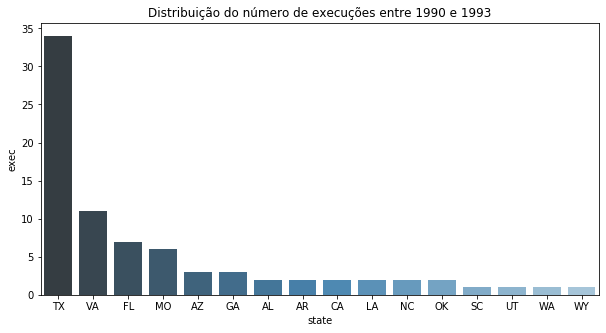

In [229]:
## pegando apenas o ano de 93
df_93 = df.loc[df['year'] == 93]

## Plotando a distribuicao do numero de execucoes de estados com pelo menos uma execucao
df_93_0 = df_93.loc[df_93['exec'] > 0]
# arrumando o df para ficar em ordem descendente e dropando o index anterior
df_93_0 = df_93_0.sort_values(['exec'], ascending=False).reset_index(drop=True)

fig, axs = plt.subplots(figsize = (10,5))

ax0 = sns.barplot(x="state",y="exec", data=df_93_0, palette="Blues_d")
ax0.set_title("Distribuição do número de execuções entre 1990 e 1993")

In [222]:
display(df_93_0)

,state,mrdrte,exec,unem,d90,d93,cmrdrte,cexec,cunem,cexec_1,cunem_1,year,TX
0,TX,11.900000,34,7.0,0,1,-2.200001,23.0,0.8,-11.0,-2.2,93,1
1,VA,8.300000,11,5.0,0,1,-0.500000,8.0,0.7,-1.0,0.1,93,0
2,FL,8.900000,7,7.0,0,1,-1.800000,-1.0,1.1,1.0,0.6,93,0
3,MO,11.300000,6,6.4,0,1,2.500000,1.0,0.7,5.0,-0.6,93,0
4,AZ,8.600000,3,6.2,0,1,0.900001,3.0,0.9,0.0,-0.9,93,0
5,GA,11.400000,3,5.8,0,1,-0.400001,1.0,0.4,-7.0,-0.1,93,0
6,AL,11.600000,2,7.5,0,1,0.000000,-3.0,0.7,3.0,-1.0,93,0
7,AR,10.200000,2,6.2,0,1,-0.100000,0.0,-0.7,2.0,-1.2,93,0
8,CA,13.100000,2,9.2,0,1,1.200001,2.0,3.6,0.0,-0.2,93,0
9,LA,20.299999,2,7.4,0,1,3.099998,-2.0,1.2,-5.0,-5.8,93,0


In [223]:
## Dropando o Texas
df['TX'] = df['state'].apply(lambda i: 1 if i == 'TX' else 0)

## Criando um df novo e arrumanndo
df_tx = df.loc[(df['TX'] != 1) & (df['year'] != 87)]
df_tx.reset_index(drop=True)
df_tx.set_index(['state','year'])

mrdrte  exec  unem  d90  d93  cmrdrte  cexec  cunem  cexec_1  \
state year                                                                 
AL    90      11.6     5   6.8    1    0      2.3    3.0   -1.0      NaN   
      93      11.6     2   7.5    0    1      0.0   -3.0    0.7      3.0   
AK    90       7.5     0   6.9    1    0     -2.6    0.0   -3.9      NaN   
      93       9.0     0   7.6    0    1      1.5    0.0    0.7      0.0   
AZ    90       7.7     0   5.3    1    0      0.2    0.0   -0.9      NaN   
...            ...   ...   ...  ...  ...      ...    ...    ...      ...   
WV    93       6.9     0  10.8    0    1      1.2    0.0    2.5      0.0   
WI    90       4.6     0   4.4    1    0      1.1    0.0   -1.7      NaN   
      93       4.4     0   4.7    0    1     -0.2    0.0    0.3      0.0   
WY    90       4.9     0   5.4    1    0      2.9    0.0   -3.2      NaN   
      93       3.4     1   5.4    0    1     -1.5    1.0    0.0      0.0   

            cunem_1  TX  
state year               
AL    90        NaN   0  
      93       -1.0   0  
AK    90        NaN   0  
      93       -3.9   0  
AZ    90        NaN   0  
...             ...  ..  
WV    93       -2.5   0  
WI    90        NaN   0  
      93       -1.7   0  
WY    90        NaN   0  
      93       -3.2   0  

[100 rows x 11 columns]

In [224]:
## estimando por PD
x = df_tx[['d93','exec','unem']]
y = df_tx['mrdrte']

Reg_Painel_Primeiras_Diferenças(x,y)

                     FirstDifferenceOLS Estimation Summary                      
Dep. Variable:                 mrdrte   R-squared:                        0.1031
Estimator:         FirstDifferenceOLS   R-squared (Between):             -0.0283
No. Observations:                  50   R-squared (Within):               0.1031
Date:                Sat, Mar 13 2021   R-squared (Overall):             -0.0281
Time:                        16:01:11   Log-likelihood                   -73.646
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.8001
Entities:                          51   P-value                           0.1601
Avg Obs:                       1.9608   Distribution:                    F(3,47)
Min Obs:                       0.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             1.8001
                            

In [227]:
## usando os tres anos e estimando por efeitos fixos
x = df[['year','exec','unem']]
y = df['mrdrte']

Reg_Painel_Efeitos_Fixos(x,y)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 mrdrte   R-squared:                        0.0734
Estimator:                   PanelOLS   R-squared (Between):              0.0037
No. Observations:                 153   R-squared (Within):               0.0734
Date:                Sat, Mar 13 2021   R-squared (Overall):              0.0108
Time:                        16:04:09   Log-likelihood                   -375.63
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.9398
Entities:                          51   P-value                           0.1098
Avg Obs:                       3.0000   Distribution:                    F(4,98)
Min Obs:                       3.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             1.9398
                            

## Exercício C9

In [211]:
coletar_dados('PENSION')

PENSION.dta foi lido com sucesso!


,id,pyears,prftshr,choice,female,married,age,educ,finc25,finc35,finc50,finc75,finc100,finc101,wealth89,black,stckin89,irain89,pctstck
0,38,1.0,0,1,0,1,64,12,0,0,1,0,0,0,77.900002,0,1,1,0
1,152,6.0,1,1,1,1,56,13,0,0,0,1,0,0,154.899994,0,1,1,50
2,152,25.0,1,1,0,1,56,12,0,0,0,1,0,0,154.899994,0,1,1,50
3,182,20.0,1,0,1,1,63,12,1,0,0,0,0,0,232.500000,0,1,1,100
4,222,35.0,0,1,0,1,67,12,0,1,0,0,0,0,179.000000,0,0,1,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,4935,3.0,0,1,1,1,57,17,0,0,0,0,1,0,116.000000,0,0,0,100
190,4936,2.0,1,0,1,1,60,9,1,0,0,0,0,0,163.800003,0,0,0,100
191,4964,24.0,0,1,0,1,61,16,0,0,0,0,1,0,246.000000,0,1,1,50
192,5014,29.0,1,0,1,1,58,17,1,0,0,0,0,0,213.000000,0,0,0,100


In [212]:
df.columns

Index(['id', 'pyears', 'prftshr', 'choice', 'female', 'married', 'age', 'educ',
       'finc25', 'finc35', 'finc50', 'finc75', 'finc100', 'finc101',
       'wealth89', 'black', 'stckin89', 'irain89', 'pctstck'],
      dtype='object')

In [213]:
## estimando sem considerar agrupamento; o efeito de choice é marginalmente significante a 5% e amplia significativamente o percentual de ações no portfolio (+≈11,7%)
x = df[['prftshr', 'choice', 'female', 'age', 'educ', 'finc25', 'finc35', 'finc50', 'finc75', 'finc100', 'finc101','wealth89', 'stckin89', 'irain89']]
y = df['pctstck']

Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                pctstck   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1.542
Date:                Mon, 15 Mar 2021   Prob (F-statistic):              0.100
Time:                        21:43:06   Log-Likelihood:                -978.02
No. Observations:                 194   AIC:                             1986.
Df Residuals:                     179   BIC:                             2035.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        128.5442     55.170      2.330      0.0

In [214]:
## fazendo um teste f; as variáveis são est não significantes
rest = df[['finc25', 'finc35', 'finc50', 'finc75', 'finc100', 'finc101','wealth89', 'stckin89', 'irain89']]
Teste_F(x,y,rest)

O valor de F é 1.031 e seu p-valor é 0.4171607. Portanto, não se rejeita Ho à significância de 5.0%.


In [215]:
## calculando o número de famílias no df
print(f"O número de famílias é {df['id'].nunique()}.")

O número de famílias é 171.


In [216]:
## estimando considerando erros padrão clusterizados
X = sm.add_constant(x)

Modelo = sm.OLS(y,X)
Resultado = Modelo.fit(cov_type='cluster',cov_kwds={'groups':df['id']}, use_t = True)

print(Resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                pctstck   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     2.248
Date:                Mon, 15 Mar 2021   Prob (F-statistic):            0.00796
Time:                        21:43:11   Log-Likelihood:                -978.02
No. Observations:                 194   AIC:                             1986.
Df Residuals:                     179   BIC:                             2035.
Df Model:                          14                                         
Covariance Type:              cluster                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        128.5442     56.961      2.257      0.0

In [217]:
def Regressao_Multipla(x, y, constante = "S", cov = "normal"):
    '''
    Função que calcula uma regressão múltipla, sendo, por default, computada com um intercepto e com erros padrões não robustos.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" para erros-padrões clusterizados
    '''

    global Resultado, Lista_ychapeu, Resíduos, SQR, EPR

    #adicionando uma constante ao modelo de Ordinary Least Squares (OLS)
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x

    #Criando o Modelo levando em conta a opção de ser uma regressão robusta p/ heteroscedasticidade ou não
    Modelo = sm.OLS(y,X)

    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'HC1', use_t = True)
    elif cov == "cluster":
        group = str(input("Qual o rótulo da coluna de grupo?"))
        try:
            Resultado = Modelo.fit(cov_type = 'cluster',cov_kwds  ={'groups':df[group]}, use_t = True)
        except:
            print("Não foi possível encontrar o grupo selecionado. Tente novamente!")
            strzero = str(0)
            return strzero
    else:
        Resultado = Modelo.fit()
    
    Lista_ychapeu = Resultado.predict()
    Resíduos = y - Lista_ychapeu

    #Calculando o Erro Padrão da Regressão (EPR)
    SQR =sum([i**2 for i in Resíduos])
    Número_de_Observações = len(y)
    GL = Número_de_Observações - len(Resultado.params)
    VarianciaReg = SQR/GL
    EPR = math.sqrt(VarianciaReg)
    
    ##Printando o Resultado
    print(Resultado.summary())

    print(f"O erro padrão da regressão é {round(EPR,5)} e a SQR é {round(SQR,5)}")
    print("\nPara ver os valores previstos ou os resídudos, basta chamar 'Lista_ychapeu' e 'Resíduos'.")
    print("Os resultados do modelo podem ser obtidos através de métodos usando a variável 'Resultado'.")
    print("""
    Valores de condição maiores que 20 indicam problemas de multicolinearidade.
    Para ver como achar esse número, entre em https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html"""
    )

In [218]:
Regressao_Multipla(x,y,cov='cluster')

                            OLS Regression Results                            
Dep. Variable:                pctstck   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     2.248
Date:                Mon, 15 Mar 2021   Prob (F-statistic):            0.00796
Time:                        21:43:31   Log-Likelihood:                -978.02
No. Observations:                 194   AIC:                             1986.
Df Residuals:                     179   BIC:                             2035.
Df Model:                          14                                         
Covariance Type:              cluster                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        128.5442     56.961      2.257      0.0

In [219]:
## diferenciando apenas com os dados de famílias (id aparecendo mais que uma vez)
# agrupando por id (e selecionando todas as colunas) e pegando apenas os ids cujo numero de linhas (shape[0]) seja maior que 2
df = pd.DataFrame(df.groupby('id').filter(lambda x : x['id'].shape[0]>=2))

In [220]:
# criando uma coluna de observacoes com valores [1,2]
df['obs'] = np.resize([1,2], df['id'].shape[0])

In [221]:
## arrumando o painel
Arrumar_Painel()
clear_output()

In [222]:
# vendo como ele ficou
df.head(10)

pyears  prftshr  choice  female  married  age  educ  finc25  finc35  \
id  obs                                                                        
152 1       6.0        1       1       1        1   56    13       0       0   
    2      25.0        1       1       0        1   56    12       0       0   
233 1       2.0        0       1       1        1   64    12       1       0   
    2      10.0        1       0       1        1   64    12       1       0   
460 1      40.0        0       0       1        1   67    12       0       0   
    2      18.0        0       1       0        1   69    16       0       0   
490 1       2.0        0       1       1        1   58    12       0       1   
    2       2.0        0       1       1        1   58    12       0       1   
888 1      10.0        0       0       1        1   63    12       0       0   
    2      10.0        0       0       0        1   67    12       0       0   

         finc50  finc75  finc100  finc101    wealth89  black  stckin89  \
id  obs                                                                  
152 1         0       1        0        0  154.899994      0         1   
    2         0       1        0        0  154.899994      0         1   
233 1         0       0        0        0   52.000000      0         0   
    2         0       0        0        0   52.000000      0         0   
460 1         0       0        1        0  292.000000      0         0   
    2         0       0        1        0  292.000000      0         0   
490 1         0       0        0        0  147.899994      0         0   
    2         0       0        0        0  147.899994      0         0   
888 1         1       0        0        0  219.550003      0         0   
    2         1       0        0        0  219.550003      0         0   

         irain89  pctstck obs  
id  obs                        
152 1          1       50   1  
    2          1       50   2  
233 1          1      100   1  
    2          1      100   2  
460 1          1      100   1  
    2          1        0   2  
490 1          0       50   1  
    2          0       50   2  
888 1          1       50   1  
    2          1        0   2

In [223]:
##criando as colunas de variação
variaveis = df[['prftshr', 'choice', 'female', 'age', 'educ','pctstck']]

for i in variaveis:
    df[f'c{i}'] = df[i].diff()

## selecionando apenas as linhas com as colunas de variação
df_2 = df.loc[df['obs'] == 2]

In [224]:
## fazendo a regressão de PD COM INTERCEPTO
# ve-se que todas as variáveis são est insignificantes - isso ocorre em razao do baixo numero de observacoes e da baixa variancia em virtude de pessoas da mesma familia terem caracteristicas similares (consequentemente, a diferença entre as variáveis ser muito pequena)
x = df_2[['cprftshr', 'cchoice', 'cfemale', 'cage', 'ceduc',]]
y = df_2['cpctstck']

Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:               cpctstck   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                    0.8821
Date:                Mon, 15 Mar 2021   Prob (F-statistic):              0.514
Time:                        21:44:12   Log-Likelihood:                -110.38
No. Observations:                  23   AIC:                             232.8
Df Residuals:                      17   BIC:                             239.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9267     10.938      1.456      0.1

In [234]:
def equation():
    '''
    Função que gera uma equação formatada do word
    '''
    
    ## capturando os parametros e os erros
    params = dict(np.around(Resultado.params,3))
    ## linearmodels usa .std_erros para capturar os erros padrão, sm usa .bse
    try:
        std_errors = dict(np.around(Resultado.std_errors,5))
    except:
        std_errors = dict(np.around(Resultado.bse,5))

    ## fazendo o loop para pegar os coeficientes*nome das variáveis e os seus erros-padrão entre parênteses
    parametros = ""
    erros = ""
    for i in params.keys():
        erros += f" & ({std_errors[i]})"
        if i != 'const':
            if params[i] > 0:
                parametros += f" & + {params[i]}{i}"
            else:
                parametros += f" & - {-params[i]}{i}"
        else:
            parametros += f"{params[i]}"
    
    ## Fazendo a str que irá pro word (em forma de matriz)
    inicio = "\matrix{"
    fim = "}"

    # linearmodels usa model.dependente; sm usa model.endog_names
    try:
        y = Resultado.model.dependent.dataframe.columns[0]
    except:
        y = Resultado.model.endog_names
    word = f"{inicio}{y} & = & {parametros} \\\ & {erros}{fim}"

    ## Adicionando o numero de obs e os r2
    # linearmodels usa .entity_info['total'] no numero de observações, sm usa nobs
    try:
        word += f"\nn = {int(dict(Resultado.entity_info)['total'])}; R^2 = {np.around(Resultado.rsquared,3)}"
    except:
         word += f"\nn = {int(Resultado.nobs)}; R^2 = {np.around(Resultado.rsquared,3)}; R\\bar^2 = {np.around(Resultado.rsquared_adj,3)}"

    ## substituindo os . por ,
    word = word.replace(".",",")
    
    ## copiando para o clipboard e printando o sucesso
    subprocess.run("pbcopy", universal_newlines=True, input=word)
    print("O código da equação foi copiado para o clipboard!")

In [235]:
equation()

O código da equação foi copiado para o clipboard!


## Exercício C12

In [237]:
coletar_dados('ELEM94_95')

ELEM94_95.dta foi lido com sucesso!


,distid,schid,lunch,enrol,staff,exppp,avgsal,avgben,math4,story4,bs,lavgsal,lenrol,lstaff
0,1010.0,4937,48.299999,539.0,71.099998,3586.0,39383.0,13656.0,68.000000,70.699997,0.346749,10.581090,6.289716,4.264087
1,2010.0,4959,51.500000,59.0,127.099998,4357.0,25622.0,10004.0,40.000000,40.000000,0.390446,10.151207,4.077538,4.844974
2,2020.0,4999,51.200001,82.0,122.599998,5667.0,31318.0,12645.0,57.099998,57.099998,0.403761,10.351949,4.406719,4.808927
3,2070.0,597,33.700001,409.0,77.500000,2752.0,27873.0,9657.0,63.200001,73.500000,0.346464,10.235414,6.013715,4.350278
4,3010.0,790,11.900000,259.0,87.599998,3253.0,31264.0,10017.0,56.400002,64.099998,0.320400,10.350223,5.556828,4.472781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,83010.0,2210,62.799999,303.0,64.199997,3049.0,37658.0,12231.0,52.000000,58.000000,0.324792,10.536301,5.713733,4.162003
1844,83010.0,2480,50.000000,281.0,65.500000,2997.0,33885.0,11884.0,49.000000,74.500000,0.350716,10.430728,5.638355,4.182050
1845,83010.0,5101,41.000000,281.0,64.800003,2983.0,36244.0,12120.0,70.400002,77.800003,0.334400,10.498029,5.638355,4.171306
1846,83060.0,5901,0.000000,506.0,76.599998,3302.0,31165.0,11462.0,53.400002,66.099998,0.367784,10.347051,6.226537,4.338597


In [238]:
## Vendo o total de escolas por distrito
escolas = pd.DataFrame(df.groupby('distid')['schid'].count())
escolas['distid'] = escolas.index
escolas

,schid,distid
distid,,
1010.0,1,1010.0
2010.0,1,2010.0
2020.0,1,2020.0
2070.0,1,2070.0
3010.0,3,3010.0
...,...,...
82405.0,5,82405.0
82430.0,6,82430.0
83010.0,5,83010.0


In [239]:
## vendo quantos distritos tem uma escola
len(escolas.loc[escolas['schid'] == 1])

271

In [240]:
print(f"O valor mínimo de escolas por distrito é {min(escolas['schid'])}.")
print(f"O valor máximo de escolas por distrito é {max(escolas['schid'])}.")
print(f"O valor médio de escolas por distrito é {escolas['schid'].mean()}.")

O valor mínimo de escolas por distrito é 1.
O valor máximo de escolas por distrito é 162.
O valor médio de escolas por distrito é 3.441340782122905.


In [241]:
Arrumar_Painel()

lunch  enrol       staff   exppp   avgsal   avgben  \
distid  schid                                                           
1010.0  4937   48.299999  539.0   71.099998  3586.0  39383.0  13656.0   
2010.0  4959   51.500000   59.0  127.099998  4357.0  25622.0  10004.0   
2020.0  4999   51.200001   82.0  122.599998  5667.0  31318.0  12645.0   
2070.0  597    33.700001  409.0   77.500000  2752.0  27873.0   9657.0   
3010.0  790    11.900000  259.0   87.599998  3253.0  31264.0  10017.0   
...                  ...    ...         ...     ...      ...      ...   
83010.0 2210   62.799999  303.0   64.199997  3049.0  37658.0  12231.0   
        2480   50.000000  281.0   65.500000  2997.0  33885.0  11884.0   
        5101   41.000000  281.0   64.800003  2983.0  36244.0  12120.0   
83060.0 5901    0.000000  506.0   76.599998  3302.0  31165.0  11462.0   
83070.0 2527    0.000000  528.0   58.700001  2482.0  30549.0  10685.0   

                   math4     story4        bs    lavgsal    lenrol    lstaff  \
distid  schid                                                                  
1010.0  4937   68.000000  70.699997  0.346749  10.581090  6.289716  4.264087   
2010.0  4959   40.000000  40.000000  0.390446  10.151207  4.077538  4.844974   
2020.0  4999   57.099998  57.099998  0.403761  10.351949  4.406719  4.808927   
2070.0  597    63.200001  73.500000  0.346464  10.235414  6.013715  4.350278   
3010.0  790    56.400002  64.099998  0.320400  10.350223  5.556828  4.472781   
...                  ...        ...       ...        ...       ...       ...   
83010.0 2210   52.000000  58.000000  0.324792  10.536301  5.713733  4.162003   
        2480   49.000000  74.500000  0.350716  10.430728  5.638355  4.182050   
        5101   70.400002  77.800003  0.334400  10.498029  5.638355  4.171306   
83060.0 5901   53.400002  66.099998  0.367784  10.347051  6.226537  4.338597   
83070.0 2527   43.900002  62.099998  0.349766  10.327087  6.269096  4.072440   

              schid  
distid  schid        
1010.0  4937   4937  
2010.0  4959   4959  
2020.0  4999   4999  
2070.0  597     597  
3010.0  790     790  
...             ...  
83010.0 2210   2210  
        2480   2480  
        5101   5101  
83060.0 5901   5901  
83070.0 2527   2527  

[1848 rows x 13 columns]

In [242]:
## fazendo um mqo agrupado
x = df[['bs','lenrol','lstaff','lunch']]
y = df['lavgsal']

Reg_Painel_MQO_Agrupado(x,y)

                          PooledOLS Estimation Summary                          
Dep. Variable:                lavgsal   R-squared:                        0.4882
Estimator:                  PooledOLS   R-squared (Between):              0.2866
No. Observations:                1848   R-squared (Within):               0.5393
Date:                Tue, Mar 16 2021   R-squared (Overall):              0.4882
Time:                        08:08:59   Log-likelihood                    689.98
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      439.43
Entities:                         537   P-value                           0.0000
Avg Obs:                       3.4413   Distribution:                  F(4,1843)
Min Obs:                       1.0000                                           
Max Obs:                       162.00   F-statistic (robust):             439.43
                            

In [9]:
def Reg_Painel_MQO_Agrupado(x, y, constante = "S", cov = "normal"):
    '''
    Função que calcula uma regressão por MQO agrupado, sendo, por default, computada com um intercepto e com erros padrões  robustos.
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" ou "clustered" para erros-padrões clusterizados
    '''
    global df, Resultado
    
    # formando o vetor de variáveis independentes
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    
    #Criando o Modelo levando em conta a opção do erro padrão
    Modelo = PooledOLS(y,X)

    if cov == "robusta":
        Resultado = Modelo.fit(cov_type = 'robust')
    elif cov == 'clustered' or cov == 'cluster':
        Resultado = Modelo.fit(cov_type = 'clustered',cluster_entity=True)
    else:
        Resultado = Modelo.fit()
    print(Resultado)

In [10]:
## Fazendo MQO Agrupado com erros clusterizados
Reg_Painel_MQO_Agrupado(x,y,cov='cluster')

                          PooledOLS Estimation Summary                          
Dep. Variable:                lavgsal   R-squared:                        0.4882
Estimator:                  PooledOLS   R-squared (Between):              0.2866
No. Observations:                1848   R-squared (Within):               0.5393
Date:                Sun, Mar 14 2021   R-squared (Overall):              0.4882
Time:                        19:01:19   Log-likelihood                    689.98
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      439.43
Entities:                         537   P-value                           0.0000
Avg Obs:                       3.4413   Distribution:                  F(4,1843)
Min Obs:                       1.0000                                           
Max Obs:                       162.00   F-statistic (robust):             129.94
                            

In [11]:
## Pegando apenas as observações com bs < 0.5
df = df.loc[df['bs'] <= 0.5]

x = df[['bs','lenrol','lstaff','lunch']]
y = df['lavgsal']

Reg_Painel_MQO_Agrupado(x,y,cov='cluster')

                          PooledOLS Estimation Summary                          
Dep. Variable:                lavgsal   R-squared:                        0.4889
Estimator:                  PooledOLS   R-squared (Between):              0.2908
No. Observations:                1844   R-squared (Within):               0.5412
Date:                Sun, Mar 14 2021   R-squared (Overall):              0.4889
Time:                        19:01:24   Log-likelihood                    707.02
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      439.70
Entities:                         537   P-value                           0.0000
Avg Obs:                       3.4339   Distribution:                  F(4,1839)
Min Obs:                       1.0000                                           
Max Obs:                       161.00   F-statistic (robust):             133.60
                            

In [12]:
## fazendo estimações por efeitos fixos
x = df[['bs','lenrol','lstaff','lunch']]
y = df['lavgsal']

Reg_Painel_Efeitos_Fixos(x,y)

                          PanelOLS Estimation Summary                           
Dep. Variable:                lavgsal   R-squared:                        0.5759
Estimator:                   PanelOLS   R-squared (Between):              0.2774
No. Observations:                1844   R-squared (Within):               0.5759
Date:                Sun, Mar 14 2021   R-squared (Overall):              0.4555
Time:                        19:01:27   Log-likelihood                    2045.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      442.37
Entities:                         537   P-value                           0.0000
Avg Obs:                       3.4339   Distribution:                  F(4,1303)
Min Obs:                       1.0000                                           
Max Obs:                       161.00   F-statistic (robust):             442.37
                            